<a href="https://colab.research.google.com/github/yimgakevin/machine-learning/blob/main/apprentissage_supervise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apprentissage supervisé

Chargement et installation des packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import polars as pl

In [2]:
# importer les packages
REGRESSION_TARGET = "prix"
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import polars as pl

In [3]:
# importer les transaction immobiliére avec polar
transactions = pl.read_parquet("/content/transactions_immobilieres.parquet")

In [4]:
"""
On se restreint au périmètre de la capture d'écran;
Ici nous utilisons la syntaxe de Polars. Mais un équivalent Pandas serait

transactions_regression_2D = transacations[
    (transactions["departement"] == 75)
    & (transactions[REGRESSION_TARGET] >= transactions[REGRESSION_TARGET].quantile(0.1))
][["surface_habitable", REGRESSION_TARGET]]
"""


'\nOn se restreint au périmètre de la capture d\'écran;\nIci nous utilisons la syntaxe de Polars. Mais un équivalent Pandas serait\n\ntransactions_regression_2D = transacations[\n    (transactions["departement"] == 75)\n    & (transactions[REGRESSION_TARGET] >= transactions[REGRESSION_TARGET].quantile(0.1))\n][["surface_habitable", REGRESSION_TARGET]]\n'

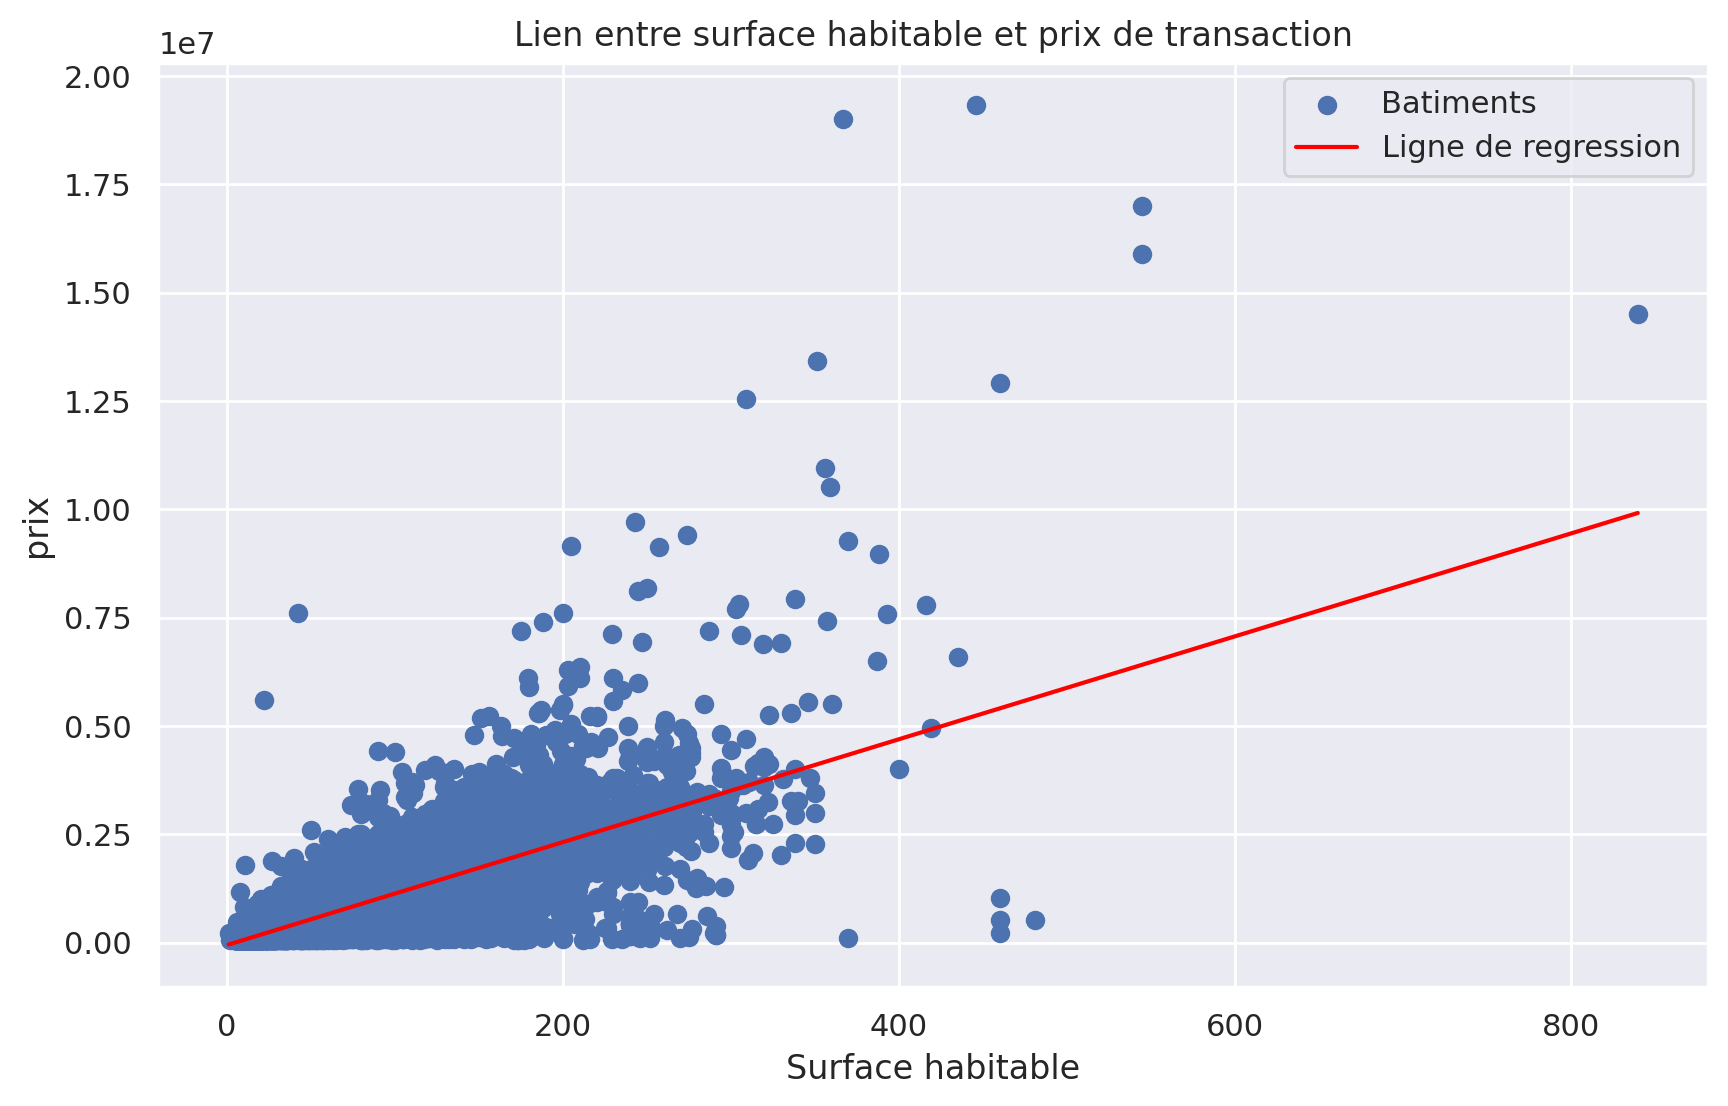

In [5]:
transactions_regression_2D = transactions.filter(
    pl.col("departement") == 75, # on filtre uniquement les transactions du département 75 (Paris).
    pl.col(REGRESSION_TARGET) >= pl.quantile(REGRESSION_TARGET, 0.1), # on enlève les 10% de valeurs les plus basses pour la variable cible
).select(["surface_habitable", REGRESSION_TARGET]) # on garde seulement deux colonne

# On crée un modèle de régression linéaire qui essaie d'expliquer la target à partir de la feature choisie
linear_regressor_2D = LinearRegression()
"""
A l'heure d'écriture de ce code, Scikit-learn ne supporte pas les Polars DataFrame directement.
Il faut alors réaliser une conversion en numpy array, le format au coeur de la majorité des opération Scikit-learn aujourd'hui
"""

linear_regressor_2D.fit(
    transactions_regression_2D["surface_habitable"].to_numpy().reshape(-1, 1), # convertion en numpy car polars n'est pas lu directement avec scikit learn
    transactions_regression_2D[REGRESSION_TARGET].to_numpy(), # convertion en numpy car polars n'est pas lu directement avec scikit learn
)

# On trace un nuage de points classique des batiments
plt.figure(figsize=(10, 6),dpi=200)
plt.scatter(
    transactions_regression_2D["surface_habitable"],
    transactions_regression_2D[REGRESSION_TARGET],
    label="Batiments",)
# Simulation de points factices, simplement pour générer la droite
surface_habitable_range = np.linspace(
    transactions_regression_2D["surface_habitable"].min(),
    transactions_regression_2D["surface_habitable"].max(),
    100,
).reshape(-1, 1)

predictions = linear_regressor_2D.predict(surface_habitable_range) #On demande au modèle de donner ses prédictions de prix pour les 100 valeurs de surface générées.

# Ajout de la ligne de regression

plt.plot(surface_habitable_range, predictions, color="red", label="Ligne de regression")
plt.xlabel("Surface habitable")
plt.ylabel(REGRESSION_TARGET)
plt.title("Lien entre surface habitable et prix de transaction")
plt.legend()
plt.show()

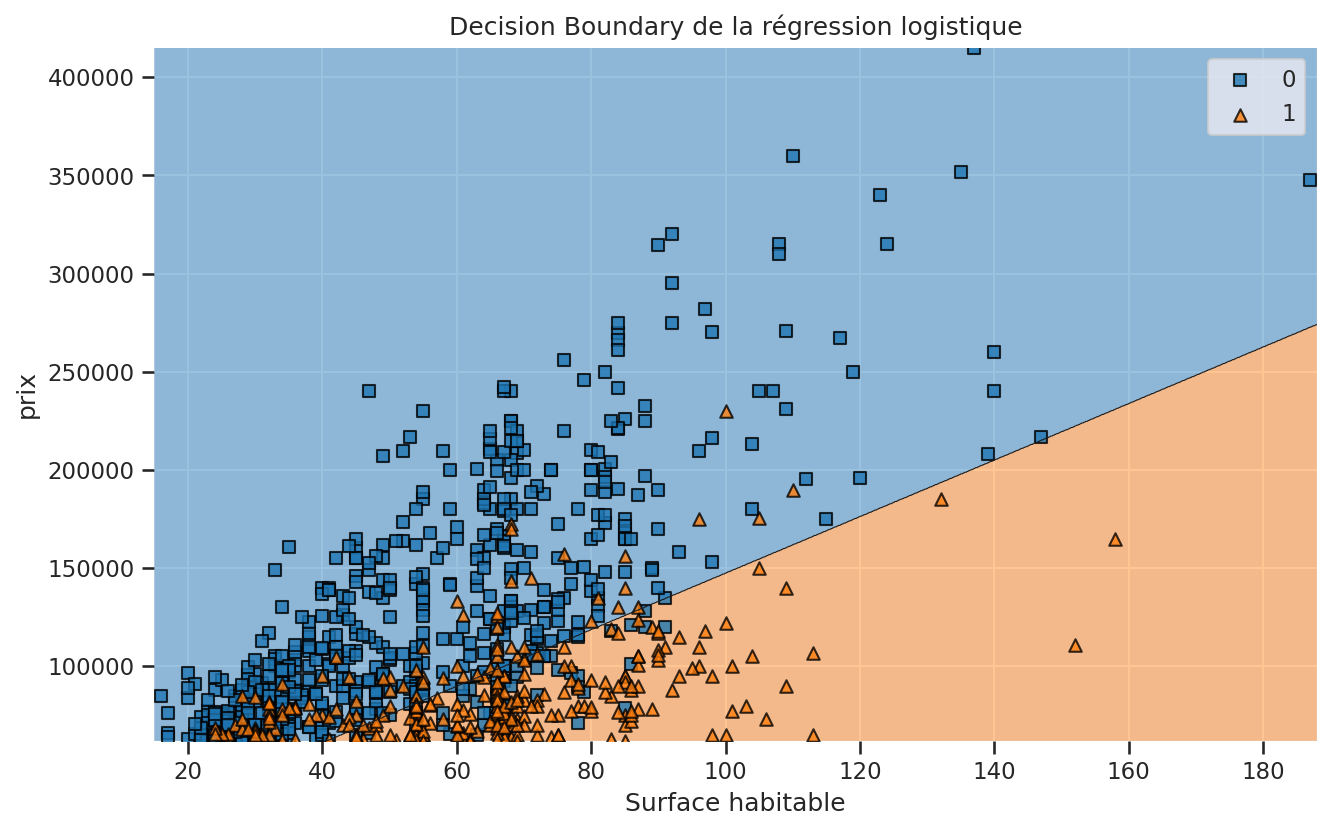

In [6]:
CLASSIFICATION_TARGET = "en_dessous_du_marche" # definition du nom de colonne qui sera notre variable cible
from mlxtend.plotting import plot_decision_regions # (librairie mlxtend) : (plot_decision_regions):permet de tracer graphiquement la frontière de décision d’un classifieur
from sklearn.linear_model import LogisticRegression

# Nous choissons ces 2 features uniquement pour illustrer le concept !

transactions_classification_3D = transactions.filter(
    pl.col("departement") == 4, # filtrer les transactions et ne garder que les transactions du département 4
    pl.col(REGRESSION_TARGET) >= pl.quantile(REGRESSION_TARGET, 0.1), # on enlève les 10% de prix les plus bas (outliers ou anomalies).
).select(["surface_habitable", REGRESSION_TARGET, CLASSIFICATION_TARGET]) # On ne garde que les 3 colonnes ci

# on entraine notre regression logistique
logistic_regressor = LogisticRegression() # On instancie un modèle de régression logistique.

X = transactions_classification_3D.select(["surface_habitable", "prix"]).to_numpy() # conversion en tableau numpy, car scikit-learn n’accepte pas les DataFrame Polars directement
y = transactions_classification_3D[CLASSIFICATION_TARGET].to_numpy() # conversion en tableau numpy, car scikit-learn n’accepte pas les DataFrame Polars directement

logistic_regressor.fit(X, y) #On entraîne le modèle de régression logistique avec X (features) et y (cible).

# Nous faisons appel à cette librairie pour tracer la frontière de décision
plt.figure(figsize=(10, 6),dpi=150)
plot_decision_regions(X, y, clf=logistic_regressor, legend=2)
plt.xlabel("Surface habitable")
plt.ylabel(REGRESSION_TARGET)
plt.title("Decision Boundary de la régression logistique")
plt.legend()
plt.show()


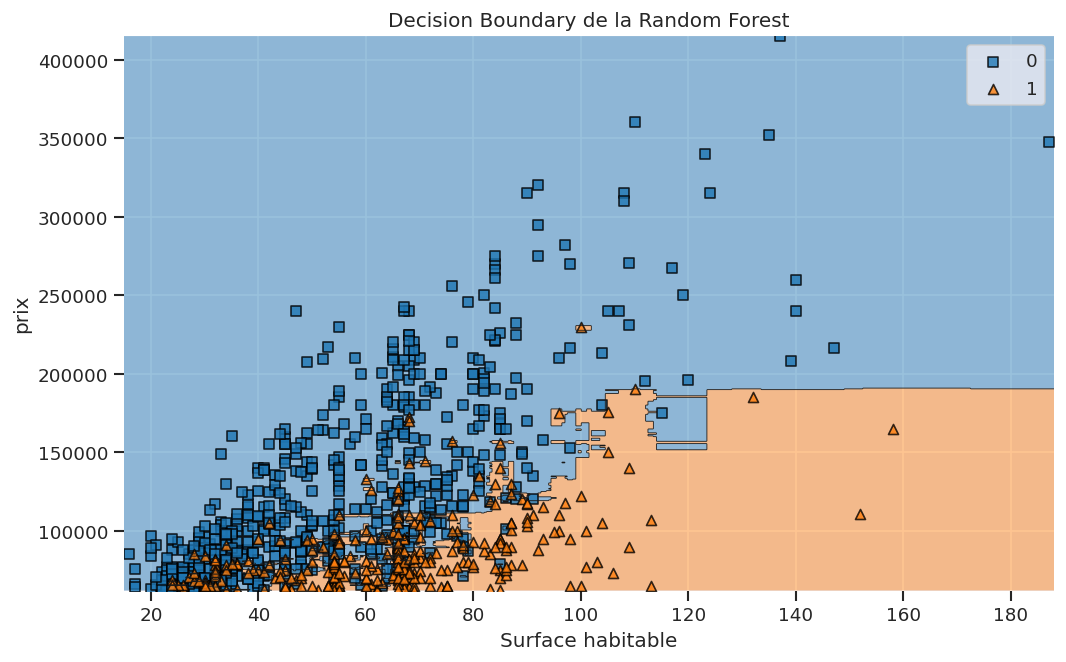

In [7]:
from sklearn.ensemble import RandomForestClassifier

# On entraine notre Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier .fit(X, y)

# Nous faisons appel à cette librairie pour tracer la frontière de décision
plt.figure(figsize=(10, 6),dpi=120)
plot_decision_regions(X, y, clf=rf_classifier , legend=2)
plt.xlabel("Surface habitable")
plt.ylabel(REGRESSION_TARGET)
plt.title("Decision Boundary de la Random Forest")
plt.legend()
plt.show()

Exercice 1.2

In [8]:
# A REMPLACER EN FONCTION DE LA LOCALISATION DE VOTRE DONNEE DANS VOTRE DOSSIER
transactions = pl.read_parquet("transactions_immobilieres.parquet")

On va se limiter au pérmiètre suivant pour cet exercice

In [9]:
transactions_exercice = transactions.filter(
    pl.col("departement") == 75,
).select(["surface_habitable", "n_pieces", "prix", "vefa", "mois_transaction", "annee_transaction"])


X = transactions_exercice.drop("prix")
y = transactions_exercice["prix"]

In [10]:
# importer la librairie statmodels
import statsmodels.api as sm

On entraine la regression linéaire avec la syntaxe de statsmodels. Cette librairie n'est malheureusement pas compatible avec Polars, nous devons le convertir en DataFrame Pandas avec la méthode to_pandas()

In [11]:
linear_regressor = sm.OLS(endog = y.to_pandas(), exog = X.to_pandas()).fit()

La méthode summary() nous donne toutes les informations pertinentes sur la regression linéaire

In [12]:
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   prix   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                          1.012e+05
Date:                Tue, 23 Sep 2025   Prob (F-statistic):                        0.00
Time:                        19:25:34   Log-Likelihood:                     -1.5588e+06
No. Observations:              111725   AIC:                                  3.118e+06
Df Residuals:                  111720   BIC:                                  3.118e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
surface_habitable   1.12e+04     45.771    244.598      0.000    1.11e+04    1.13e+04
n_pieces          -1.295e+04   1308.434     -9.895      0.000   -1.55e+04   -1.04e+04
vefa              -1.709e+04    1.2e+04     -1.428      0.153   -4.06e+04    6369.925
mois_transaction    435.9821    241.770      1.803      0.071     -37.883     909.847
annee_transaction    -9.5656      1.157     -8.265      0.000     -11.834      -7.297
==============================================================================
Omnibus:                   137979.569   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        357047942.483
Skew:                           5.685   Prob(JB):                         0.00
Kurtosis:                     279.712   Cond. No.                     2.91e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nous suivons le processus d'élimination backwards qui peut être résumé comme suit :

* On entraine un premier modèle avec toutes les features
* Si on a des features avec une p-valeur supérieure à 0.05, c'est que notre regression linéaire n'est pas fiable. Sinon, notre modèle est bon à être interprété et utilisé.
* Dans le premier cas, on identifie la feature avec la p-value la plus élevée. On la supprime et on réentraine le modèle.
* On répète ce processus jusqu'à l'obtention d'un assortiment de features avec des p-valeurs en dessous du seuil.

Nb: Concrétement : Présence de p-valeurs supérieurs au seuil signifie que les features n'ont pas de lien avéré statistiquement parlant avec la target, donc les coefficients associés aux features ne sont pas fiable.

In [13]:
# Il faut supprimer la variable avec la P-valeur la plus élevée
X = X.drop("vefa")

Attention : Ce serait une erreur de supprimer TOUTES les features avec un p-value supérieure au seuil de 0.05 avant de réentrainer le 2eme modèle. En effet, en supprimant qu'une seule feature, les p-valeur vont bouger de nouveau après avoir réentrainé le modèle. Il se peut qu'une toute autre feature soit au-dessus de seuil, ou bien aucune.

In [14]:
linear_regressor = sm.OLS(endog = y.to_pandas(), exog = X.to_pandas()).fit()
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   prix   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                          1.265e+05
Date:                Tue, 23 Sep 2025   Prob (F-statistic):                        0.00
Time:                        19:25:35   Log-Likelihood:                     -1.5588e+06
No. Observations:              111725   AIC:                                  3.118e+06
Df Residuals:                  111721   BIC:                                  3.118e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
surface_habitable  1.119e+04     45.765    244.606      0.000    1.11e+04    1.13e+04
n_pieces          -1.293e+04   1308.369     -9.881      0.000   -1.55e+04   -1.04e+04
mois_transaction    433.8710    241.766      1.795      0.073     -39.987     907.729
annee_transaction    -9.5972      1.157     -8.294      0.000     -11.865      -7.329
==============================================================================
Omnibus:                   137994.453   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        357093737.441
Skew:                           5.686   Prob(JB):                         0.00
Kurtosis:                     279.729   Cond. No.                     3.19e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Nous avons une fois de plus une variable dont la p-valeur est supérieure au seuil
X = X.drop("mois_transaction")

In [16]:

linear_regressor = sm.OLS(endog = y.to_pandas(), exog = X.to_pandas()).fit()
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   prix   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                          1.687e+05
Date:                Tue, 23 Sep 2025   Prob (F-statistic):                        0.00
Time:                        19:25:35   Log-Likelihood:                     -1.5588e+06
No. Observations:              111725   AIC:                                  3.118e+06
Df Residuals:                  111722   BIC:                                  3.118e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
surface_habitable  1.119e+04     45.766    244.600      0.000    1.11e+04    1.13e+04
n_pieces          -1.293e+04   1308.382     -9.881      0.000   -1.55e+04   -1.04e+04
annee_transaction    -8.2345      0.873     -9.431      0.000      -9.946      -6.523
==============================================================================
Omnibus:                   138008.265   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        357098071.616
Skew:                           5.687   Prob(JB):                         0.00
Kurtosis:                     279.731   Cond. No.                     3.19e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## feature engineering

On appelle **Feature Engineering** la procédure qui consiste à créer des features à partir d’autres features existantes, où à partir de la donnée source dont elles sont issues.

In [17]:
# charger le jeu de données
transactions = pl.read_parquet("/content/transactions_immobilieres.parquet")

In [18]:
transactions

id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,mois_transaction,annee_transaction,prix_m2,prix_m2_moyen,nb_transactions_mois,en_dessous_du_marche,code_departement,nom_departement,code_region,nom_region,region
i32,datetime[ns],f64,i32,i32,str,i32,str,str,i32,i32,i32,str,f64,f64,i32,i32,f64,f64,u32,i32,str,str,i64,str,i32
83094,2018-01-03 00:00:00,98000.0,1,53,"""BOURG-EN-BRESSE""",1000,"""8 RUE TRAVERSIERE""","""Appartement""",0,3,70,"""01053000AD0289""",46.204952,5.225964,1,2018,1400.0,1229.764459,17,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
70798,2018-01-04 00:00:00,225000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""62 RUE VOLTAIRE""","""Appartement""",0,2,56,"""01143000AN0176""",46.355345,6.137488,1,2018,4017.857143,4512.419826,9,1,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
77488,2018-01-04 00:00:00,67000.0,1,53,"""BOURG-EN-BRESSE""",1000,"""12 ALL DE LA PETITE REYSSOUZE""","""Appartement""",0,1,45,"""01053000BD0227""",46.201122,5.23721,1,2018,1488.888889,1229.764459,17,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
78665,2018-01-05 00:00:00,503000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""48 RUE DE LA SCIE""","""Appartement""",0,3,82,"""01143000AH0207""",46.358948,6.145611,1,2018,6134.146341,4512.419826,9,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
72218,2018-01-05 00:00:00,339000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""151 CHE DE LA CREUSE""","""Appartement""",0,3,68,"""01143000AL0310""",46.360953,6.137112,1,2018,4985.294118,4512.419826,9,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13327794,2023-06-30 00:00:00,84960.0,95,127,"""CERGY""",95800,"""42 AV DES GENOTTES""","""Appartement""",0,1,18,"""95127000DY0046""",49.05215,2.039151,6,2023,4720.0,3726.787902,17,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13331848,2023-06-30 00:00:00,105000.0,95,306,"""HERBLAY-SUR-SEINE""",95220,"""5 RUE D ARGENTEUIL""","""Appartement""",0,1,21,"""95306000AY0164""",48.990376,2.167884,6,2023,5000.0,4502.534113,6,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13331804,2023-06-30 00:00:00,82500.0,95,500,"""PONTOISE""",95300,"""24 RUE SAINT MARTIN""","""Appartement""",0,1,24,"""95500000BH0065""",49.048112,2.09154,6,2023,3437.5,3715.050888,9,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11


In [19]:
transactions.head()

id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,mois_transaction,annee_transaction,prix_m2,prix_m2_moyen,nb_transactions_mois,en_dessous_du_marche,code_departement,nom_departement,code_region,nom_region,region
i32,datetime[ns],f64,i32,i32,str,i32,str,str,i32,i32,i32,str,f64,f64,i32,i32,f64,f64,u32,i32,str,str,i64,str,i32
83094,2018-01-03 00:00:00,98000.0,1,53,"""BOURG-EN-BRESSE""",1000,"""8 RUE TRAVERSIERE""","""Appartement""",0,3,70,"""01053000AD0289""",46.204952,5.225964,1,2018,1400.0,1229.764459,17,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
70798,2018-01-04 00:00:00,225000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""62 RUE VOLTAIRE""","""Appartement""",0,2,56,"""01143000AN0176""",46.355345,6.137488,1,2018,4017.857143,4512.419826,9,1,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
77488,2018-01-04 00:00:00,67000.0,1,53,"""BOURG-EN-BRESSE""",1000,"""12 ALL DE LA PETITE REYSSOUZE""","""Appartement""",0,1,45,"""01053000BD0227""",46.201122,5.23721,1,2018,1488.888889,1229.764459,17,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
78665,2018-01-05 00:00:00,503000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""48 RUE DE LA SCIE""","""Appartement""",0,3,82,"""01143000AH0207""",46.358948,6.145611,1,2018,6134.146341,4512.419826,9,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84
72218,2018-01-05 00:00:00,339000.0,1,143,"""DIVONNE-LES-BAINS""",1220,"""151 CHE DE LA CREUSE""","""Appartement""",0,3,68,"""01143000AL0310""",46.360953,6.137112,1,2018,4985.294118,4512.419826,9,0,"""01""","""Ain""",84,"""Auvergne-Rhône-Alpes""",84


In [20]:
transactions.tail()

id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,mois_transaction,annee_transaction,prix_m2,prix_m2_moyen,nb_transactions_mois,en_dessous_du_marche,code_departement,nom_departement,code_region,nom_region,region
i32,datetime[ns],f64,i32,i32,str,i32,str,str,i32,i32,i32,str,f64,f64,i32,i32,f64,f64,u32,i32,str,str,i64,str,i32
13327794,2023-06-30 00:00:00,84960.0,95,127,"""CERGY""",95800,"""42 AV DES GENOTTES""","""Appartement""",0,1,18,"""95127000DY0046""",49.05215,2.039151,6,2023,4720.0,3726.787902,17,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13331848,2023-06-30 00:00:00,105000.0,95,306,"""HERBLAY-SUR-SEINE""",95220,"""5 RUE D ARGENTEUIL""","""Appartement""",0,1,21,"""95306000AY0164""",48.990376,2.167884,6,2023,5000.0,4502.534113,6,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13331804,2023-06-30 00:00:00,82500.0,95,500,"""PONTOISE""",95300,"""24 RUE SAINT MARTIN""","""Appartement""",0,1,24,"""95500000BH0065""",49.048112,2.09154,6,2023,3437.5,3715.050888,9,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13325828,2023-06-30 00:00:00,298000.0,95,306,"""HERBLAY-SUR-SEINE""",95220,"""5 PL DU BOIS TORTU""","""Maison""",0,4,72,"""95306000AC0343""",49.018464,2.126248,6,2023,4138.888889,4502.534113,6,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11
13329758,2023-06-30 00:00:00,126000.0,95,500,"""PONTOISE""",95300,"""15 RUE DE L EPERON""","""Appartement""",0,1,27,"""95500000BE0306""",49.050682,2.092166,6,2023,4666.666667,3715.050888,9,0,"""95""","""Val-d'Oise""",11,"""Île-de-France""",11


In [21]:
transactions.shape

(529460, 26)

In [22]:
import polars as pl

In [23]:
!pip install settings

ERROR: Could not find a version that satisfies the requirement settings (from versions: none)
ERROR: No matching distribution found for settings


In [24]:
from settings import NB_TRANSACTIONS_PER_MONTH

In [25]:
def compute_city_features(
    transactions_per_city: pl.DataFrame,
    feature_name: str = "ville_demandee",
    grouping_columns: list = ["departement", "annee_transaction", "mois_transaction"],
    quantile_threshold=0.8,
    verbose: bool = False,
):
    nb_transactions_departement = transactions_per_city.group_by(grouping_columns).agg(
        pl.sum(NB_TRANSACTIONS_PER_MONTH).alias("nb_transactions_departement")
    )

    transactions_per_city = transactions_per_city.join(
        nb_transactions_departement,
        on=grouping_columns,
        how="left",
    )

    transactions_per_city = transactions_per_city.with_columns(
        (
            100
            * pl.col(NB_TRANSACTIONS_PER_MONTH)
            / pl.col("nb_transactions_departement")
        ).alias("ratio_transactions_ville")
    ).drop("nb_transactions_departement")

    if verbose:
        print(transactions_per_city.select("ratio_transactions_ville").describe())
    else:
        pass

    transactions_per_city = transactions_per_city.with_columns(
        pl.when(
            pl.col("ratio_transactions_ville")
            > pl.quantile("ratio_transactions_ville", quantile_threshold)
        )
        .then(1)
        .otherwise(0)
        .alias(feature_name),
    ).drop("ratio_transactions_ville")

    return transactions_per_city


In [26]:
def create_debt_ratio_features(
    contexte_macro_eco_annuel: pl.DataFrame,
    debt_ratio_col: str = "taux_endettement",
):
    contexte_macro_eco_annuel = contexte_macro_eco_annuel.with_columns(
        pl.col("date").cast(
            pl.Int32
        ),  # Simple conversion utilisée pour une jointure après
        pl.col(debt_ratio_col).diff().alias("variation_" + debt_ratio_col),
        pl.col(debt_ratio_col).diff().diff().alias("acceleration_" + debt_ratio_col),
    )

    return contexte_macro_eco_annuel


In [27]:
def calculate_interest_rate_features(
    contexte_macro_eco_mensuel: pl.DataFrame,
    aggregation_period: str,
    interest_rate_col: str,
):
    contexte_macro_eco_mensuel = contexte_macro_eco_mensuel.with_columns(
        pl.col(interest_rate_col).diff().name.prefix("variation_"),
        pl.col(interest_rate_col).diff().diff().name.prefix("acceleration_"),
    ).with_columns(
        pl.mean("variation_" + interest_rate_col)
        .rolling(index_column="date", period=aggregation_period)
        .name.prefix("moyenne_glissante_" + aggregation_period + "_"),
    )

    return contexte_macro_eco_mensuel

In [28]:
def compute_price_per_m2_features(
    average_per_month_per_city: pl.DataFrame,
    sort_columns: list = [
        "departement",
        "ville",
        "id_ville",
    ],
    aggregation_period="6mo",
):
    # Besoin de créer cette colonne pour calculer la moyenne glissante (Polars n'accepte qu'une colonne)
    """
    POLARS ARTICLE
    average_per_month_per_city = average_per_month_per_city.with_columns(
        annee_mois_transaction=pl.date(
            pl.col("annee_transaction"), pl.col("mois_transaction"), 1
        )
    )

    average_per_month_per_city = average_per_month_per_city.sort(
        sort_columns
    ).with_columns(
        pl.col("prix_m2_moyen").shift().alias("prix_m2_moyen_mois_precedent"),
        pl.col("prix_m2_nombre").shift().alias("nb_transactions_mois_precedent"),
        pl.mean("prix_m2_moyen")
        .rolling(index_column="annee_mois_transaction", period=aggregation_period)
        .alias("prix_m2_moyen_glissant_" + aggregation_period),
        pl.count("prix_m2_nombre")
        .rolling(index_column="annee_mois_transaction", period=aggregation_period)
        .alias("nb_transaction_moyen_glissant_" + aggregation_period),
    )
    POLARS ARTICLE
    """

    average_per_month_per_city = (
        average_per_month_per_city.sort(sort_columns)
        .with_columns(
            pl.col("prix_m2_moyen")
            .shift()
            .over(["departement", "ville", "id_ville"])
            .alias("prix_m2_moyen_mois_precedent"),
            pl.col(NB_TRANSACTIONS_PER_MONTH)
            .shift()
            .over(["departement", "ville", "id_ville"])
            .alias("nb_transactions_mois_precedent"),
            pl.col("prix_m2_moyen")
            .rolling_mean(window_size=6)
            .over(["departement", "ville", "id_ville"])
            .alias("prix_m2_moyen_glissant_" + aggregation_period),
            pl.col(NB_TRANSACTIONS_PER_MONTH)
            .rolling_mean(window_size=6)
            .over(["departement", "ville", "id_ville"])
            .alias("nb_transaction_moyen_glissant_" + aggregation_period),
        )
        .filter(
            pl.all_horizontal(
                pl.col(pl.Float32, pl.Float64, pl.Int32, pl.Int64).is_not_nan()
            )
        )
    )

    return average_per_month_per_city



In [29]:
"""'
VERSION DE LA FONCTION UTILISEE DANS LE CADRE DU SCREENCAST P1_C3_FEATURE_ENGINEERING

def compute_price_per_m2_features(
    average_per_month_per_city: pl.DataFrame,
    sort_columns: list = [
        "departement",
        "ville",
        "id_ville",
    ],
):
    average_per_month_per_city = (
        average_per_month_per_city.sort(sort_columns)
        .with_columns(
            pl.col("prix_m2_moyen")
            .shift()
            .over(["departement", "ville", "id_ville"])
            .alias("prix_m2_moyen_mois_precedent"),
            pl.col(NB_TRANSACTIONS_PER_MONTH)
            .shift()
            .over(["departement", "ville", "id_ville"])
            .alias("nb_transactions_mois_precedent"),
        )
        .filter(
            pl.all_horizontal(
                pl.col(pl.Float32, pl.Float64, pl.Int32, pl.Int64).is_not_nan()
            )
        )
    )

    return average_per_month_per_city
"""

'\'\nVERSION DE LA FONCTION UTILISEE DANS LE CADRE DU SCREENCAST P1_C3_FEATURE_ENGINEERING\n\ndef compute_price_per_m2_features(\n    average_per_month_per_city: pl.DataFrame,\n    sort_columns: list = [\n        "departement",\n        "ville",\n        "id_ville",\n    ],\n):\n    average_per_month_per_city = (\n        average_per_month_per_city.sort(sort_columns)\n        .with_columns(\n            pl.col("prix_m2_moyen")\n            .shift()\n            .over(["departement", "ville", "id_ville"])\n            .alias("prix_m2_moyen_mois_precedent"),\n            pl.col(NB_TRANSACTIONS_PER_MONTH)\n            .shift()\n            .over(["departement", "ville", "id_ville"])\n            .alias("nb_transactions_mois_precedent"),\n        )\n        .filter(\n            pl.all_horizontal(\n                pl.col(pl.Float32, pl.Float64, pl.Int32, pl.Int64).is_not_nan()\n            )\n        )\n    )\n\n    return average_per_month_per_city\n'

faire une analyse de correlation pour s'assurer que nos features ne vont pas pertuber l'apprentissage du modéle

In [30]:
# importer les packages nécessaires
import polars as pl
import json
import os
import sys

In [31]:
sys.path.append("..")

from settings import (
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# chargement du data frame
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

In [33]:
X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_regression = transactions[REGRESSION_TARGET]
y_classification = transactions[CLASSIFICATION_TARGET]

In [34]:
feature_names = [col for col in X.columns if col != "id_transaction"]

In [35]:
categorical_features = [col for col in feature_names if "type_batiment" in col]
categorical_features.extend(["vefa", "ville_demandee"])
categorical_features.extend([col for col in feature_names if "nom_region" in col])

In [36]:
numerical_features = [col for col in feature_names if col not in categorical_features]


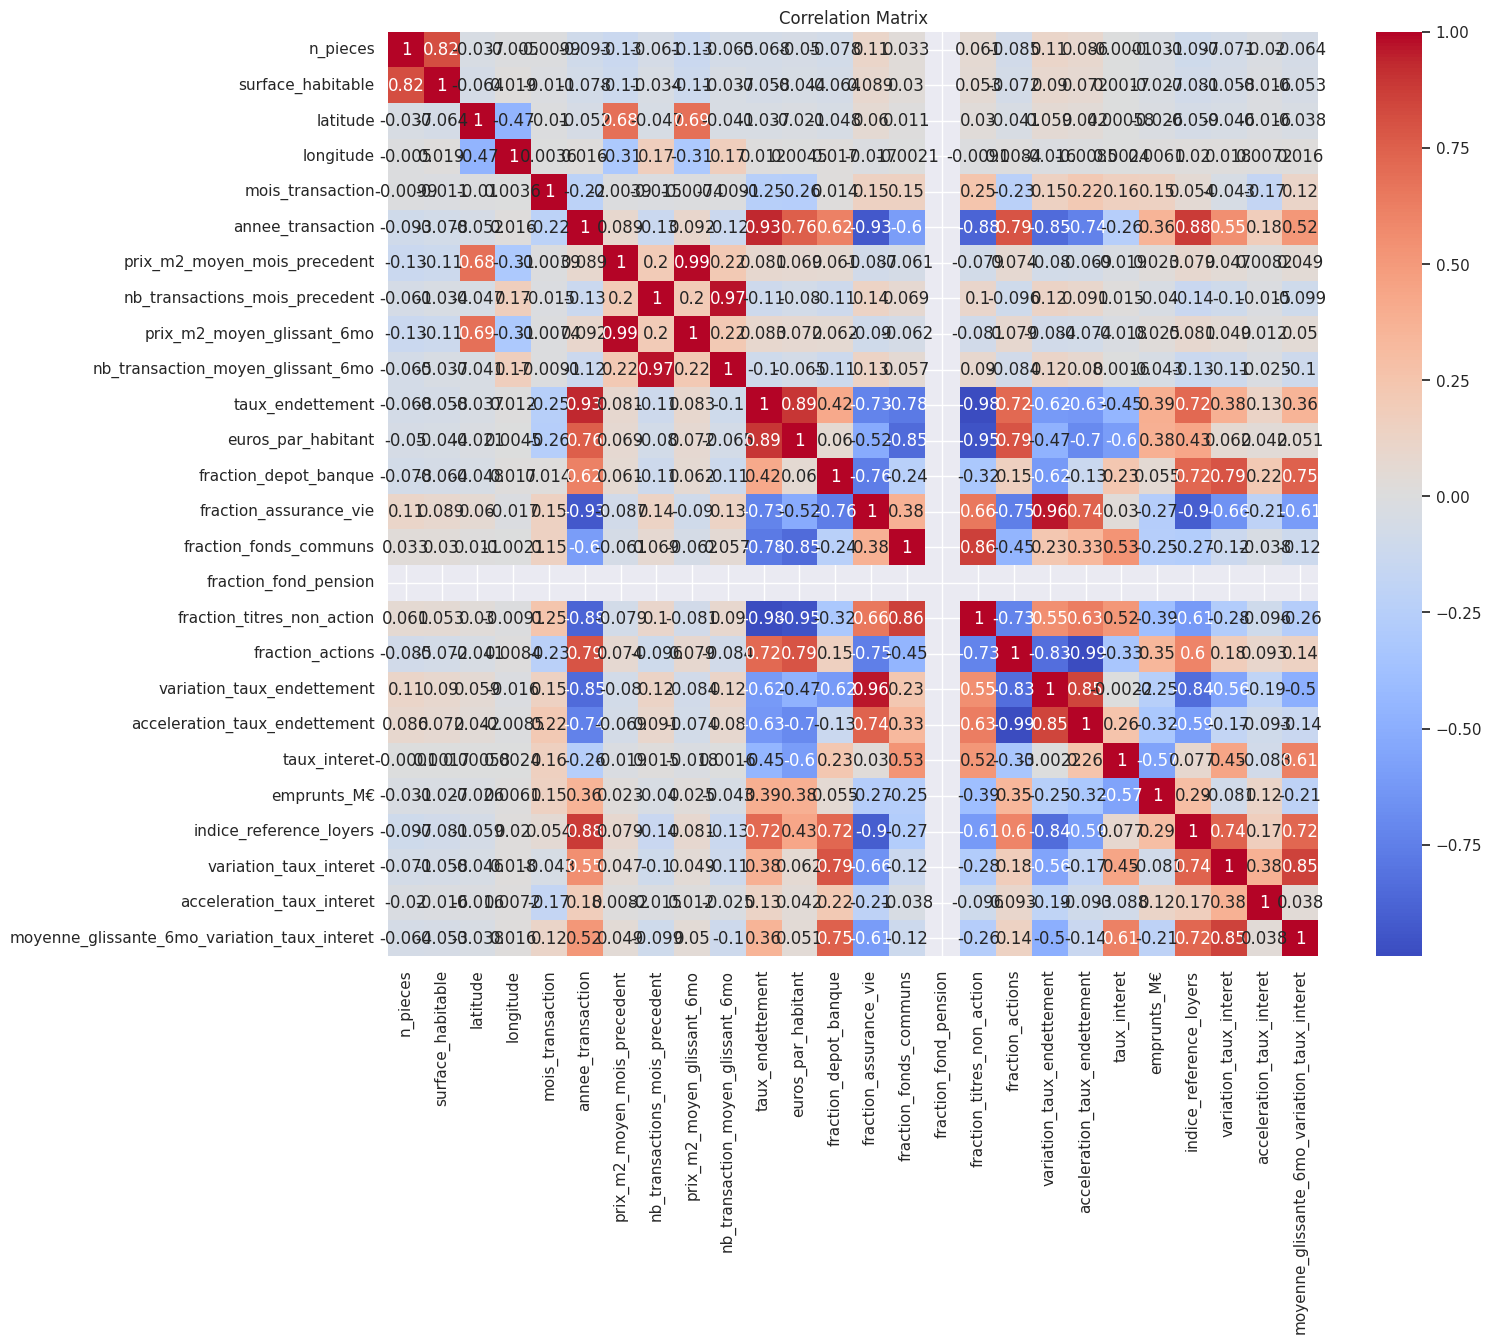

In [37]:
# tracer la matrice de correlation
correlation_matrix = X.to_pandas()[numerical_features].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [38]:
"""
Le prix moyen au m2 du mois précédent est redondant avec le prix glissant à 6 mois, ce qui indique dans la majorité des cas une évolution lente du prix au m2 du marché
Pareil pour le nombre de transactions
L'annee est très corrélée à plusieurs informations
Fraction depot banque très corrélé a
"""

"\nLe prix moyen au m2 du mois précédent est redondant avec le prix glissant à 6 mois, ce qui indique dans la majorité des cas une évolution lente du prix au m2 du marché\nPareil pour le nombre de transactions\nL'annee est très corrélée à plusieurs informations \nFraction depot banque très corrélé a\n"

In [39]:
# identifier les features qui sont proches de -1 et de 1 et les supprimer
highly_correlated_features = [
    "type_batiment_Maison",  # On garde l'une ou l'autre
    "n_pieces",  # On garde la surface habitable
    # "annee_transaction", # On garde le taux d'endettement
    "euros_par_habitant",  # Très corrélé avec le taux d'endettement
    "fraction_assurance_vie",
    "fraction_fonds_communs",
    "fraction_titres_non_action",
    "fraction_actions",
    "taux_endettement",
    "fraction_fond_pension",
    "variation_taux_endettement",
    "acceleration_taux_endettement",
    "indice_reference_loyers",
    "prix_m2_moyen_glissant_6mo",
    "nb_transaction_moyen_glissant_6mo",
    "fraction_depot_banque",
    "moyenne_glissante_6mo_variation_taux_interet",
]

In [40]:
feature_names = [col for col in feature_names if col not in highly_correlated_features]
feature_names = [
    col for col in feature_names if col not in ["prix_m2_moyen", "prix_m2_nombre"]
]

In [41]:
feature_names

['type_batiment_Appartement',
 'vefa',
 'surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'nom_region_Auvergne-Rhône-Alpes',
 'nom_region_Nouvelle-Aquitaine',
 'nom_region_Occitanie',
 "nom_region_Provence-Alpes-Côte d'Azur",
 'nom_region_Île-de-France',
 'ville_demandee',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent',
 'taux_interet',
 'emprunts_M€',
 'variation_taux_interet',
 'acceleration_taux_interet']

In [42]:
numerical_features = [col for col in feature_names if col not in categorical_features]

In [43]:
import json

with open("features_used.json", "w") as f:
    json.dump(feature_names, f)

with open("categorical_features_used.json", "w") as f:
    json.dump(categorical_features, f)

In [44]:
X = X[feature_names]

### scaling des features

Il s’agit d’une transformation où nous allons "écraser" les valeurs des features pour les ramener toutes à un ordre de grandeur commun (par exemple entre 0 et 1 ou entre 0 et 10).

In [45]:
# importer les packages nécessaires
import polars as pl
import json
import os
import sys
import pandas as pd

sys.path.append("..")

from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [46]:
# charger les données
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

In [47]:
X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])#
y_regression = transactions[REGRESSION_TARGET]


In [48]:
with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

In [49]:
# garder les colonnes qui ne contiennent que les valeutrs numériques
numerical_features = [col for col in feature_names if col not in categorical_features]

In [50]:
# entrainer le modéle
X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y_regression.to_pandas(), test_size=0.2, random_state=random_state
)

In [51]:
# importer minmaxqcaller
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [52]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [53]:
X_train_scaled_1 = standard_scaler.fit_transform(X_train[numerical_features]) # Ici il ne force pas les valeurs entre 0 et 1

In [54]:
X_train_scaled_2 = min_max_scaler.fit_transform(X_train[numerical_features]) # ordre de grandeur identique entre 0 et 1

In [55]:
X_test_scaled_1 = standard_scaler.transform(X_test[numerical_features])
X_test_scaled_2 = min_max_scaler.transform(X_test[numerical_features])

***Pourquoi le scaling avant la séparation Train-Test constitue une forme de Data Leakage ?
Si vous réalisez le scaling avant de séparer vos données en jeu de Train et de Test, vous utilisez des informations du jeu de Test pour calculer les paramètres de scaling (Min et Max du jeu de données en cas de MinMaxScaler, ou la moyenne et l'écart-type en cas de StandardScaler). Cela signifie que votre modèle a accès à des informations sur les données de test lors de la phase d'entraînement, ce qui constituerait une forme de Data Leakage.***
***
***Ce Data Leakage va causer une surestimation a performance du modèle, car il aura été entraîné sur des données qui ont été conditionnés en partie par le jeu de test qu'il verra ensuite lors de la phase de test. Cela peut conduire à une baisse de performances quand vous aurez réellement de la nouvelle donnée à disposition !***
***
***La bonne pratique est de séparer vos données en jeu de train et de test de réaliser le scaling. Vous calculez les paramètres de scaling sur l'ensemble d'entraînement, puis vous appliquez ces paramètres à l'ensemble d'entraînement et à l'ensemble de test. Cela garantit que votre modèle n'a pas accès aux données de test lors de la phase d'entraînement.***

L'approche **Model-Centric** consiste à fixer le jeu de données et à concentrer les efforts sur l'optimisation du modèle, en ajustant l'algorithme et les hyperparamètres.
***
L'approche **Data-Centric** se concentre sur l'amélioration continue des données avant d'optimiser le modèle. Cette approche est aujourd'hui largement privilégiée en entreprise.
***
**Feature Engineering** est la création de nouvelles features à partir de données existantes pour améliorer la performance du modèle. Cette étape, guidée par le contexte métier et parfois par l'intuition, est essentielle pour éviter le surapprentissage.
***
**L'analyse des corrélations entre features numériques** est cruciale pour éviter la redondance. On supprime les features très corrélées afin de garder des informations pertinentes et non répétitives.
***
**Le scaling des features** (ou normalisation) est une étape importante pour certains algorithmes de machine learning. Il permet de ramener toutes les valeurs des features à un ordre de grandeur commun, évitant ainsi que certaines features ne soient ignorées à cause de leur échelle différente.

### séparation apprentissage-test cohérente en utilisant la technique de validation croisée


In [56]:
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.path.append("..") # ceci ne nous interesse pas
from sklearn.model_selection import (
    cross_validate,
    LeaveOneGroupOut,# import des outils de la validation croisé dans sklearn
)
import polars as pl
import pandas as pd
import json
import os
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from xgboost import XGBClassifier # model ou librairie Xgboost pour la classification

In [57]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)
# recupére les listes de features depuis les fichiers json
with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)


In [58]:
# identifie les variables numériques
numerical_features = [col for col in feature_names if col not in categorical_features]

In [59]:
def perform_cross_validation(
    X: pl.DataFrame, # variables explicatives ou features
    y: pl.Series, # variables cibles ou target
    model, # modéle de machine learning à évaluer
    cross_val_type, # type de validation
    scoring_metrics: tuple,
    return_estimator=False, #Retourner les modèles entraînés ou non
    groups=None, #Groupes pour la validation (régions dans notre cas)
):
    scores = cross_validate(
        model,
        X.to_numpy(), #Conversion Polars → NumPy (scikit-learn n'accepte que NumPy/Pandas)
        y.to_numpy(), # Conversion Polars → NumPy (scikit-learn n'accepte que NumPy/Pandas)
        cv=cross_val_type,# Utilise la stratégie de validation fournie
        return_train_score=True, #Calcule les scores sur train
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups, # Utilise les groupes pour LeaveOneGroupOut(qui est un exemple de type de validation)
    )
# Moyenne et écart-type sur l'ensemble d'entraînement et de test
    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores


In [60]:
# Xgboost Modèle de gradient boosting très performant
# random_state : Assure la reproductibilité des résultats
xgboost_classifier = XGBClassifier(random_state=random_state)
classification_scoring_metrics = ("precision", "recall", "roc_auc") # calcul les metriques de classifications

In [61]:
# On va de nouveau travailler avec toutes les regions
X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_classification = transactions[CLASSIFICATION_TARGET]


In [62]:
# reconversion de notre dataframe en pandas
X_group = X.to_pandas()

In [63]:
# pd.from_dummies n'existe pas en polars raison de notre conversion en dataframe pandas
X_group["nom_region"] = pd.from_dummies(
    X_group[[col for col in X_group.columns if col.startswith("nom_region")]]
)

In [64]:
#
X_group = X_group.drop(
    [col for col in X_group.columns if col.startswith("nom_region_")], axis=1
)

In [65]:
scores_xgboost = perform_cross_validation(
    X=X_group[[col for col in feature_names if col in X_group.columns]],
    y=y_classification,
    model=xgboost_classifier,
    cross_val_type=LeaveOneGroupOut(),
    scoring_metrics=classification_scoring_metrics,
    groups=X_group["nom_region"].values,
)

Average Train precision : 0.684312601722908
Train precision Standard Deviation : 0.005906816334996818
Average Test precision : 0.46195108930624357
Test precision Standard Deviation : 0.07438551715155992
Average Train recall : 0.46307742122210094
Train recall Standard Deviation : 0.05869185797101359
Average Test recall : 0.5961509684469872
Test recall Standard Deviation : 0.1360423104300176
Average Train roc_auc : 0.7623994004974926
Train roc_auc Standard Deviation : 0.011753315820267776
Average Test roc_auc : 0.5957313195116777
Test roc_auc Standard Deviation : 0.043305638020717754


In [66]:
scores_xgboost

{'fit_time': array([10.90419912, 14.52863717, 13.61258912,  3.11508083,  3.6363678 ]),
 'score_time': array([0.62013674, 0.41379452, 0.31130219, 0.46299005, 0.82267618]),
 'test_precision': array([0.51949556, 0.44953382, 0.54441777, 0.46619686, 0.33011144]),
 'train_precision': array([0.68893574, 0.68274494, 0.67371032, 0.68587967, 0.69029235]),
 'test_recall': array([0.46524718, 0.56270071, 0.4709242 , 0.64963815, 0.8322446 ]),
 'train_recall': array([0.45047891, 0.45503283, 0.43618231, 0.39982082, 0.57387223]),
 'test_roc_auc': array([0.64906877, 0.60072992, 0.63466329, 0.5585164 , 0.53567823]),
 'train_roc_auc': array([0.76080927, 0.75947789, 0.7525441 , 0.75410213, 0.78506362])}

exercice

In [67]:
import os
import polars as pl
import sys
import json
import numpy as np
sys.path.append("..")

from settings import (
    REGRESSION_TARGET,CLASSIFICATION_TARGET, random_state, PROJECT_PATH
)

from sklearn.model_selection import cross_validate, TimeSeriesSplit
from xgboost import XGBClassifier

In [68]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

# %%
selected_region = "nom_region_Occitanie"
region_transactions = transactions.filter(pl.col(selected_region) == 1)

In [69]:
X = region_transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_classification = region_transactions[CLASSIFICATION_TARGET]

In [70]:
def perform_cross_validation(
    X: pl.DataFrame,
    y: pl.Series,
    model,
    cross_val_type,
    scoring_metrics: tuple,
    return_estimator=False,
    groups=None,
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores

In [71]:
# Ce serait une erreur de travailler avec une donnée non-triée quand on veut utiliser cette variante
X = X.sort(["annee_transaction", "mois_transaction"])

In [72]:
xgboost_classifier = XGBClassifier(random_state=random_state)
classification_scoring_metrics = ("precision", "recall", "roc_auc")

TimeSeriesSplit() est une méthode de validation croisée utilisée pour évaluer la performance d'un modèle sur des données avec une dimension temporelle. Elle divise les données en segments temporels non chevauchant, en utilisant les données du passé pour prédire les données du futur.

Lorsque vous utilisez TimeSeriesSplit(), vous spécifiez le nombre de splits (ou folds) que vous souhaitez créer. Par exemple, si vous avez 10 splits, votre jeu de données sera divisé en 10 segments temporels.

Le premier split utilise les données du début du jeu de données pour l'entraînement et les données suivantes pour le test. Le deuxième split utilise les données du début jusqu'à la fin du premier split pour l'entraînement et les données suivantes pour le test. Cette méthode est répétée jusqu'à ce que tous les splits soient créés.

Cela permet d'évaluer la performance du modèle sur des données futures, en s'assurant qu'il n'a pas accès à des informations sur le futur lors de la phase d'entraînement. Cela est particulièrement important pour les données temporelles, car les modèles doivent être capables de prédire l'avenir en se basant sur les données du passé.

In [73]:
scores_xgboost = perform_cross_validation(
    X=X[[col for col in feature_names if col in X.columns]],
    y=y_classification,
    model=xgboost_classifier,
    cross_val_type=TimeSeriesSplit(), #Par défaut, le nombre de folds est 5
    scoring_metrics=classification_scoring_metrics,
)

Average Train precision : 0.8063187793185239
Train precision Standard Deviation : 0.025054303530799696
Average Test precision : 0.4020414936114329
Test precision Standard Deviation : 0.02197911726454497
Average Train recall : 0.5062039952203331
Train recall Standard Deviation : 0.1133766257573512
Average Test recall : 0.2611411683016771
Test recall Standard Deviation : 0.05505906224996111
Average Train roc_auc : 0.8302856255364552
Train roc_auc Standard Deviation : 0.04460143976816648
Average Test roc_auc : 0.4927875519274578
Test roc_auc Standard Deviation : 0.005963241451541314


A premier abord, nous avons une dégradation considérable de la performance du modèle en test, ce qui suggère un fort overfit et une incapacité de prédire le contexte immobilier changeant avec le temps. Cela pourrait signifier que notre modèle nécéssiterait un réentrainement régulier, ou un feature engineering plus riche pour prendre en considération des informations invisibles au modèle aujourd'hui.

Si nous souhaitons pousser l'analyse plus loin, il faudrait regarder les dates exactes de début et de fin de chaque fold et regarder à quel point le contexte de la donnée à changé ! Nous savons que notre jeu de données couvre la période Juin 2018-Decembre 2022. Entre le covid et l'inflation qui a suivi, on est sur que les folds vont avoir des contextes immobiliers très différents.

Malheureusement, la fonction cross_validate ne permets pas cela ! Il faudrait utiliser une fonction avec une boucle for comme celle ci-dessous. Cela permetrait de récupérer les indices des lignes et d'analyser les périodes temporelles ainsi que leurs features en détail

In [74]:
tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 8494 8495 8496]
  Test:  index=[ 8497  8498  8499 ... 16991 16992 16993]
Fold 1:
  Train: index=[    0     1     2 ... 16991 16992 16993]
  Test:  index=[16994 16995 16996 ... 25488 25489 25490]
Fold 2:
  Train: index=[    0     1     2 ... 25488 25489 25490]
  Test:  index=[25491 25492 25493 ... 33985 33986 33987]
Fold 3:
  Train: index=[    0     1     2 ... 33985 33986 33987]
  Test:  index=[33988 33989 33990 ... 42482 42483 42484]
Fold 4:
  Train: index=[    0     1     2 ... 42482 42483 42484]
  Test:  index=[42485 42486 42487 ... 50979 50980 50981]


## Evaluation de la performance du modéle
cas 1: modéle de regréssion

### cas d'une regression

In [75]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import numpy as np
import json
import os
import sys

In [76]:
import seaborn as sns

sns.set()
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)

In [77]:
! pip install catboost

In [78]:
from catboost import CatBoostRegressor

In [79]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_regression = transactions[REGRESSION_TARGET]
y_classification = transactions[CLASSIFICATION_TARGET]

with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]


In [80]:
catboost_regressor = CatBoostRegressor(random_state=random_state, verbose=False)

X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y_regression.to_pandas(), random_state=random_state
)

In [81]:
catboost_regressor.fit(X_train[feature_names], y_train)

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_pred = catboost_regressor.predict(X_train[feature_names])
y_test_pred = catboost_regressor.predict(X_test[feature_names])

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train RMSE : ", train_rmse)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE : ", train_mae)
train_r2 = r2_score(y_train, y_train_pred)
print("Train R2 : ", train_r2)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE : ", test_rmse)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE : ", test_mae)
test_r2 = r2_score(y_test, y_test_pred)
print("Test R2 : ", test_r2)

Train RMSE :  113740.46476701723
Train MAE :  55064.49430890357
Train R2 :  0.8402266131050192
Test RMSE :  140868.19508808406
Test MAE :  57932.89029812538
Test R2 :  0.7472628449337577


In [83]:
absolute_errors_train = pd.Series(
    [
        abs(true_value - predicted_value)
        for (true_value, predicted_value) in zip(y_train, y_train_pred)
    ]
)

absolute_errors_test = pd.Series(
    [
        abs(true_value - predicted_value)
        for (true_value, predicted_value) in zip(y_test, y_test_pred)
    ]
)

print(absolute_errors_train.describe().apply(lambda x: format(x, "f")))
print(absolute_errors_test.describe().apply(lambda x: format(x, "f")))


count     336879.000000
mean       55064.494309
std        99522.983243
min            0.180541
25%        12383.520029
50%        28771.575570
75%        59875.792163
max      5265308.038244
dtype: object
count     112293.000000
mean       57932.890298
std       128404.732924
min            1.176355
25%        12513.290237
50%        28915.551752
75%        60619.138227
max      7161810.265273
dtype: object


In [84]:
def plot_regression_predictions(
    model, X, y, title="Regression Model: Predicted vs Target"
):
    y_pred = model.predict(X)

    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot(
        [min(y), max(y)],
        [min(y), max(y)],
        color="red",
        linestyle="--",
    )
    plt.xlabel("Target")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()


In [85]:
def plot_regression_error(
    model,
    X,
    y,
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
    title="Distribution of Regression Model Error",
):
    y_pred = model.predict(X)
    errors = y - y_pred

    sns.displot(errors)
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.xlim(xlim_min, xlim_max)
    plt.title(title)
    plt.show()

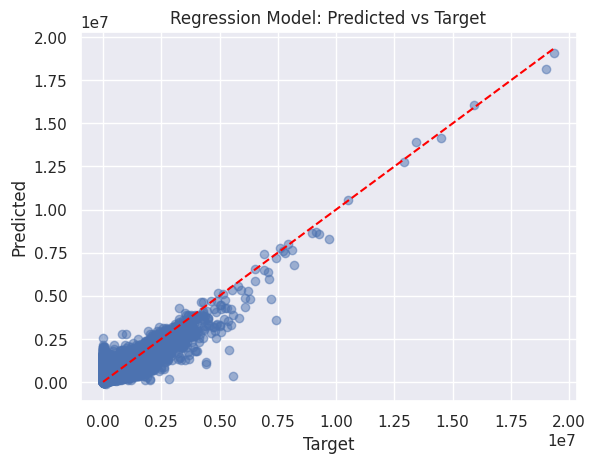

In [86]:
plot_regression_predictions(catboost_regressor, X_train[feature_names], y_train)

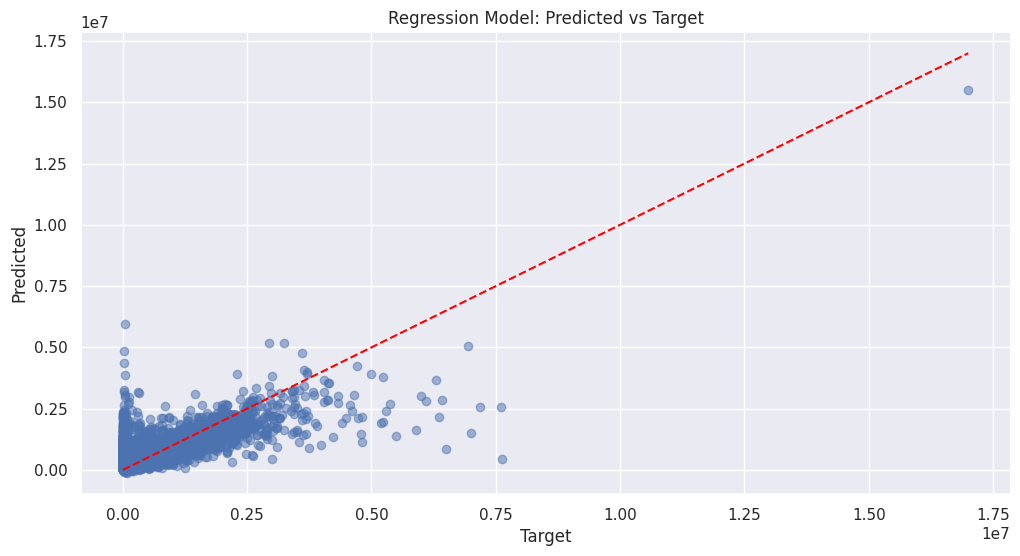

In [87]:
plt.figure(figsize=(12, 6))
plot_regression_predictions(catboost_regressor, X_test[feature_names], y_test)

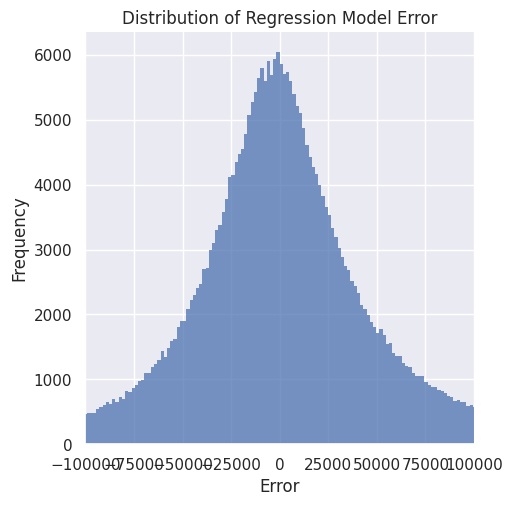

In [88]:

plot_regression_error(
    catboost_regressor,
    X_train[feature_names],
    y_train,
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
)

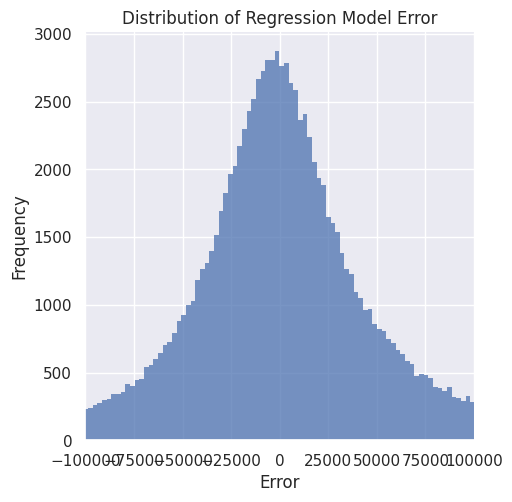

In [89]:
plot_regression_error(
    catboost_regressor,
    X_test[feature_names],
    y_test,
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
)

In [90]:
def get_X_y_particular_feature_value(
    X: pd.DataFrame, y: pd.Series, feature_col: str, feature_value
):
    X["target"] = y
    X_filtered = X[X[feature_col] == feature_value]

    return X_filtered.drop(["target"], axis=1), X_filtered["target"]


regions_features = [col for col in feature_names if col.startswith("nom_region")]
X_train_y_train_regions = {
    region: get_X_y_particular_feature_value(X_train, y_train, region, 1)
    for region in regions_features
}

X_test_y_test_regions = {
    region: get_X_y_particular_feature_value(X_test, y_test, region, 1)
    for region in regions_features
}


<Figure size 1300x1000 with 0 Axes>

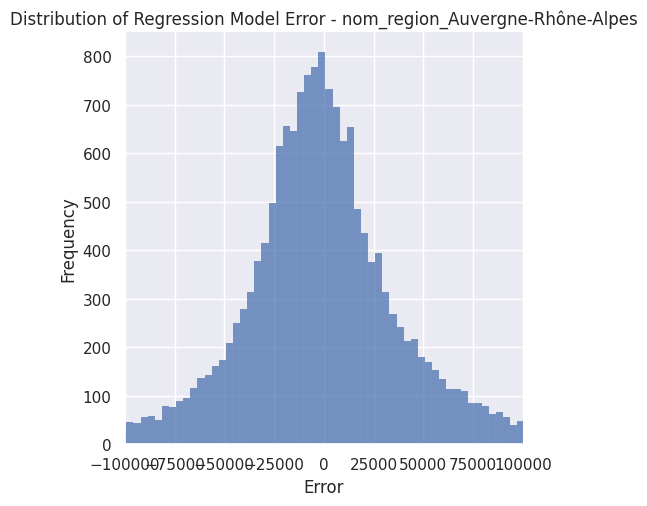

<Figure size 1300x1000 with 0 Axes>

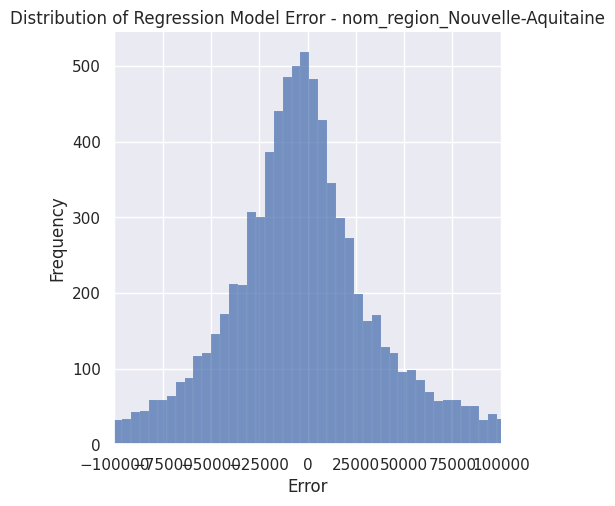

<Figure size 1300x1000 with 0 Axes>

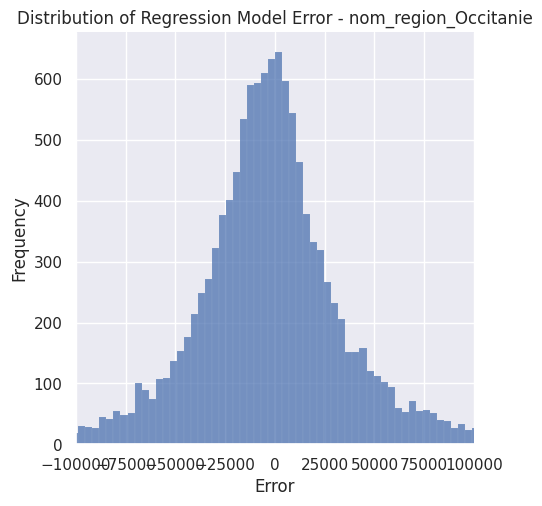

<Figure size 1300x1000 with 0 Axes>

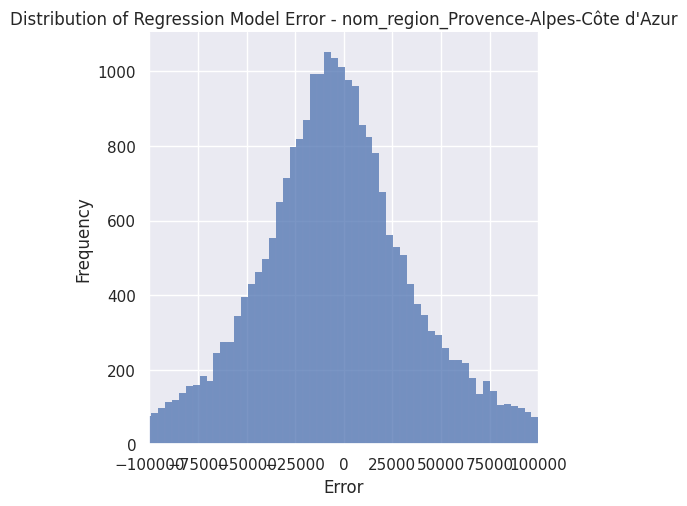

<Figure size 1300x1000 with 0 Axes>

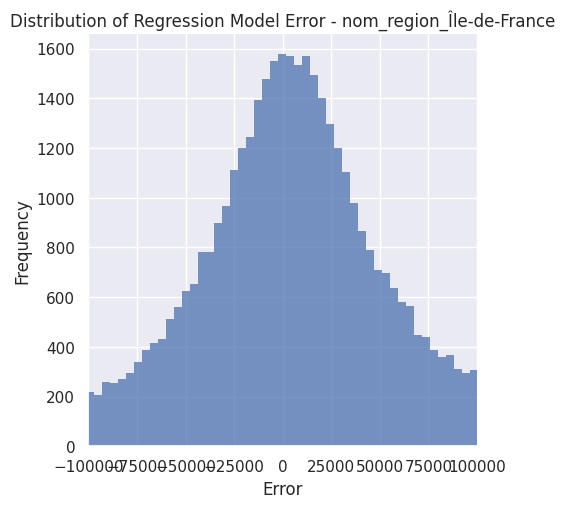

In [91]:
for region in regions_features:
    plt.figure(figsize=(13, 10))
    plot_regression_error(
        catboost_regressor,
        X_test_y_test_regions[region][0][feature_names],
        X_test_y_test_regions[region][1],
        title="Distribution of Regression Model Error - {region}".format(region=region),
    )

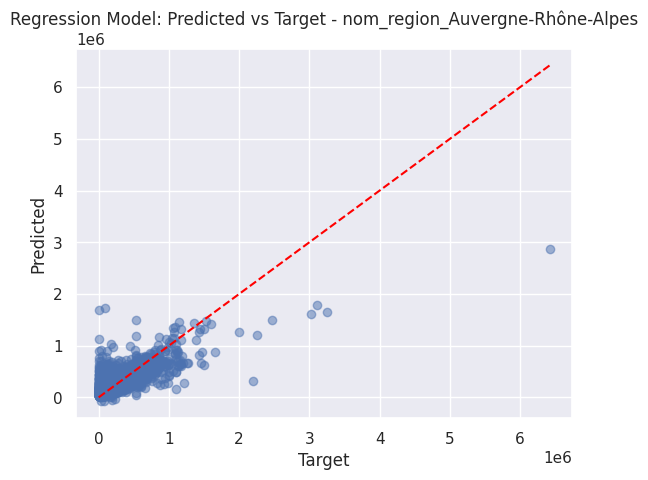

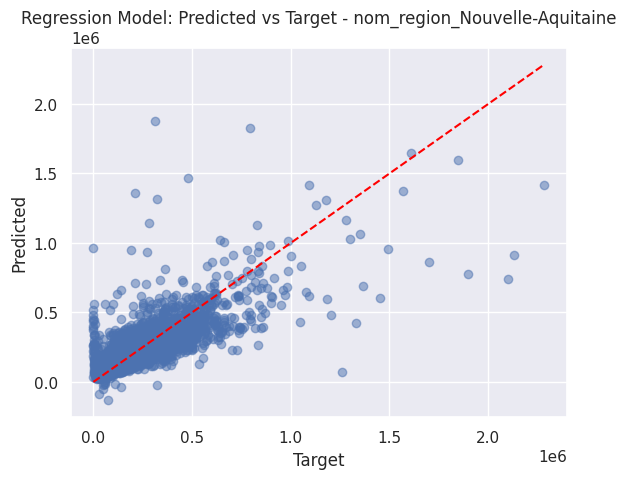

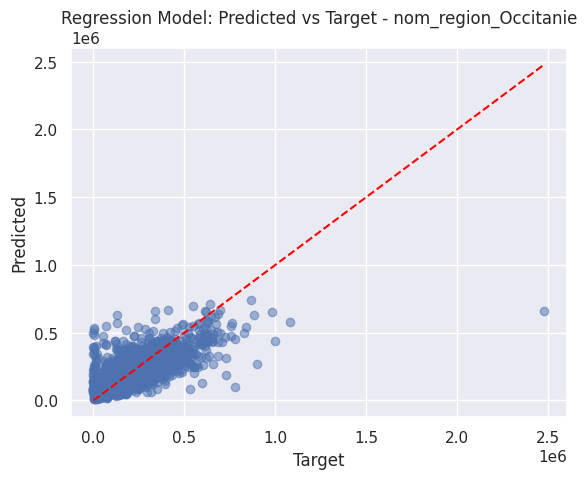

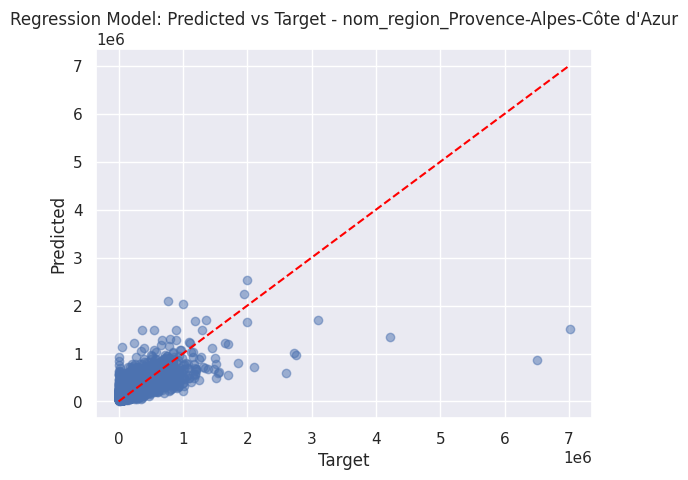

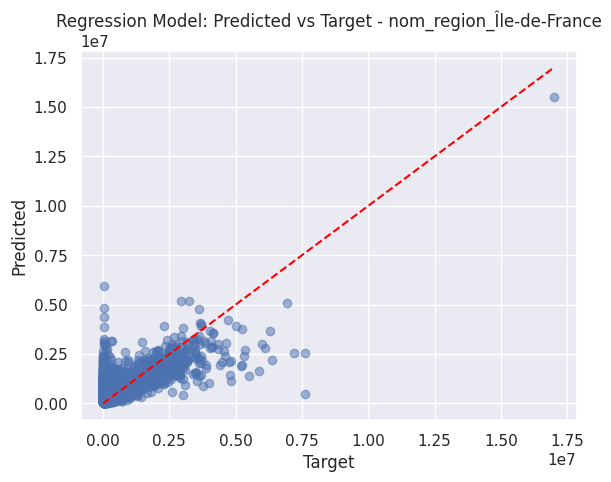

In [92]:
for region in regions_features:
    plot_regression_predictions(
        catboost_regressor,
        X_test_y_test_regions[region][0][feature_names],
        X_test_y_test_regions[region][1],
        title="Regression Model: Predicted vs Target - {region}".format(region=region),
    )

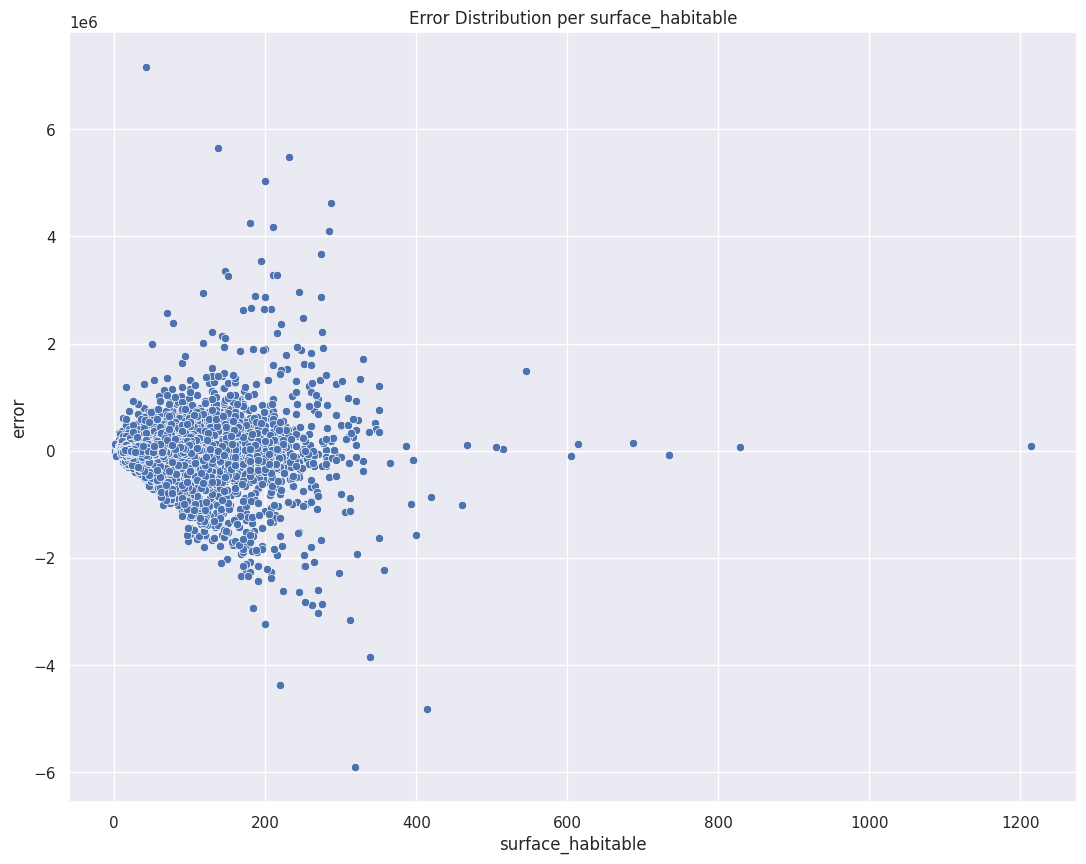

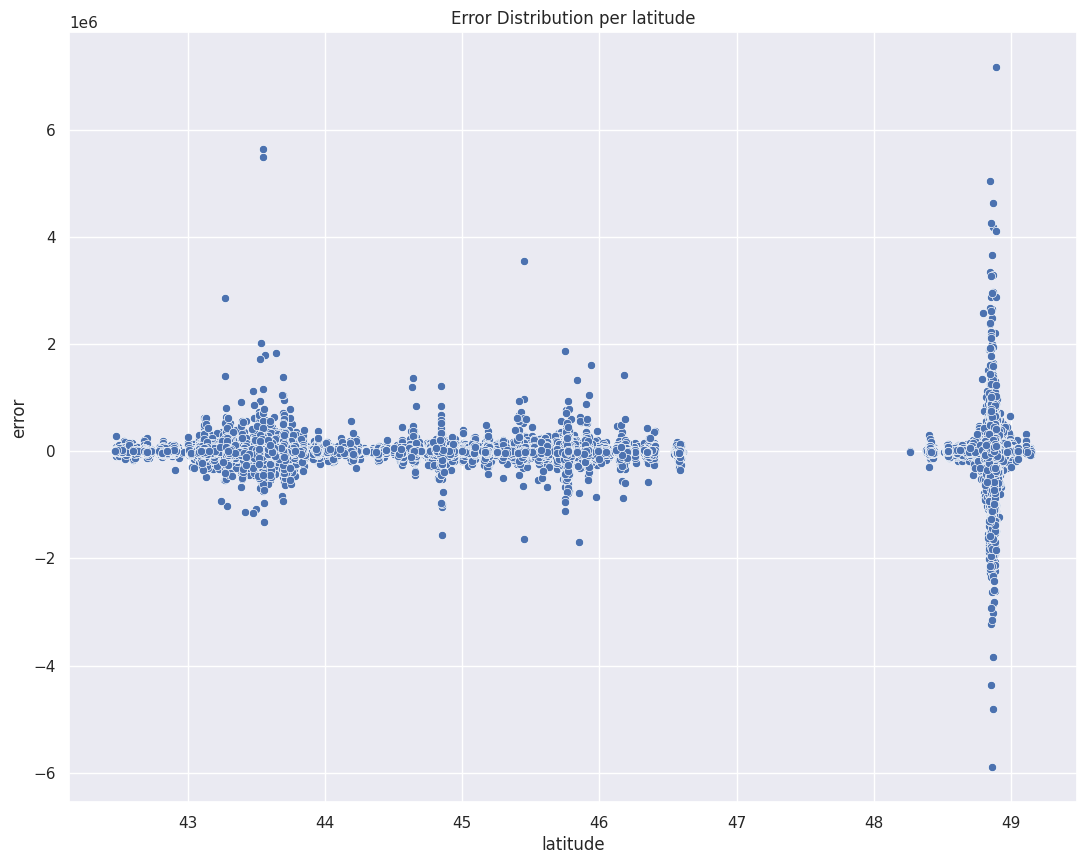

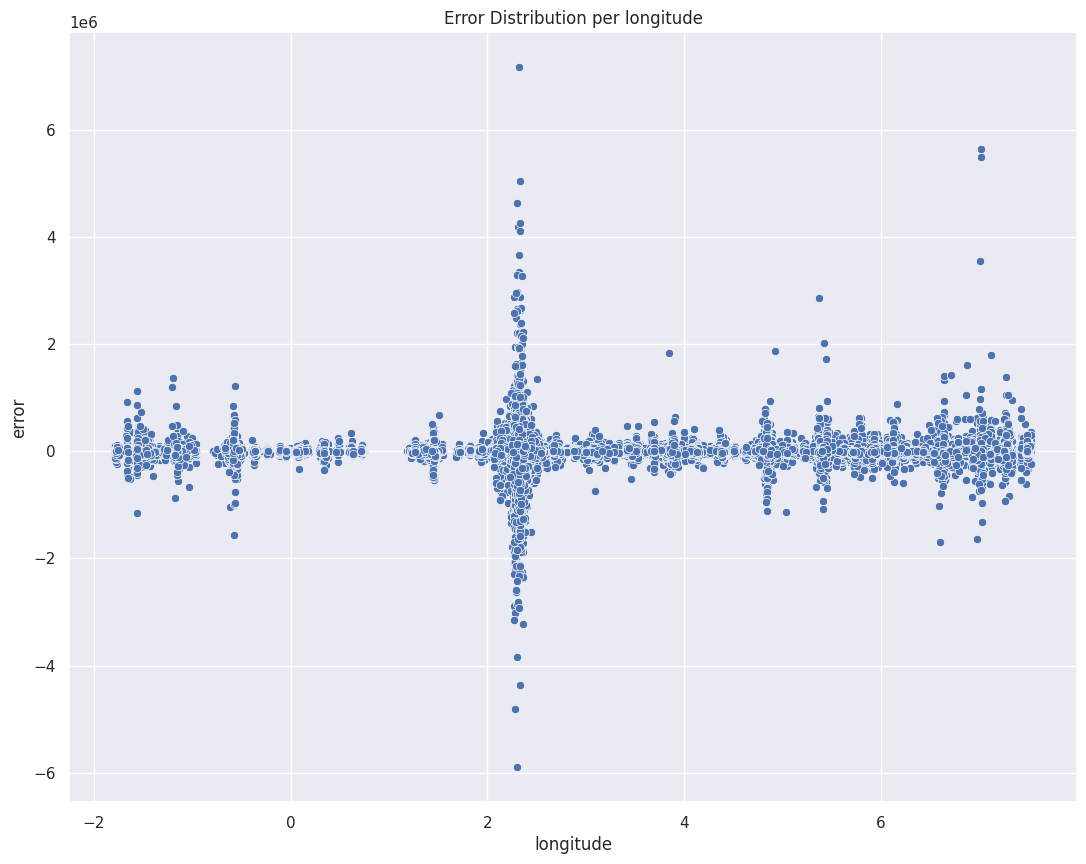

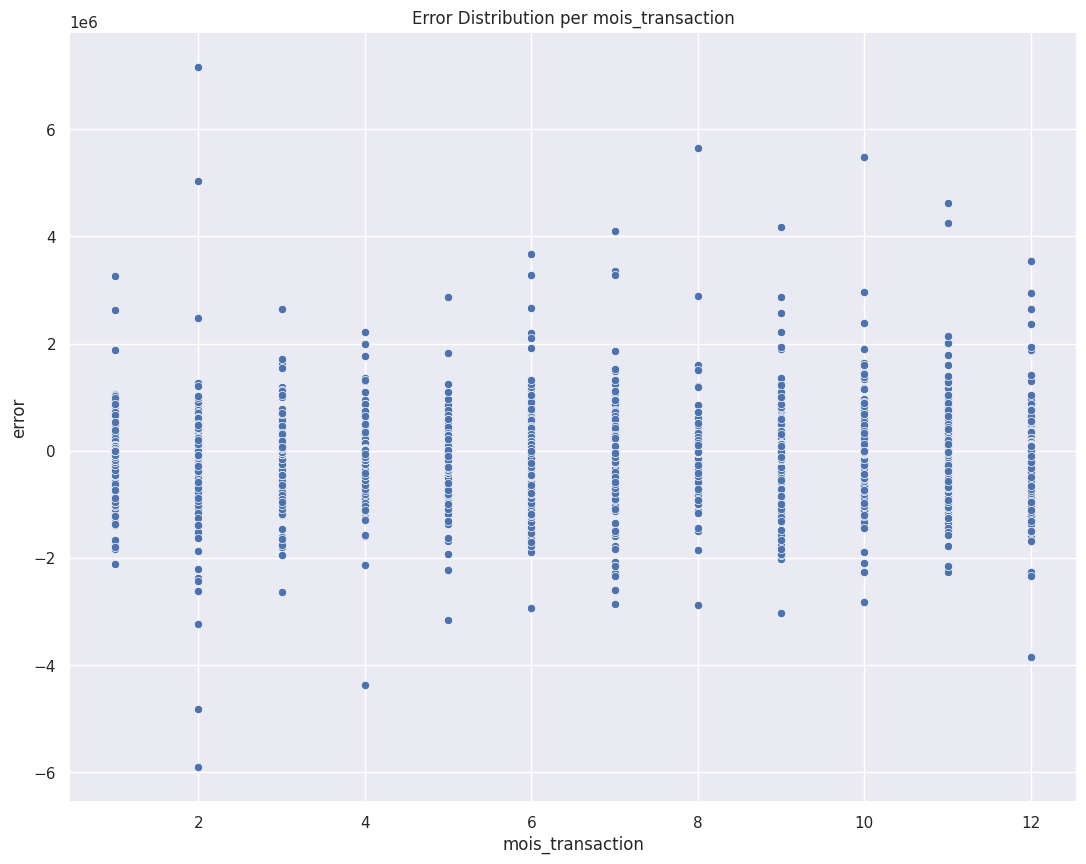

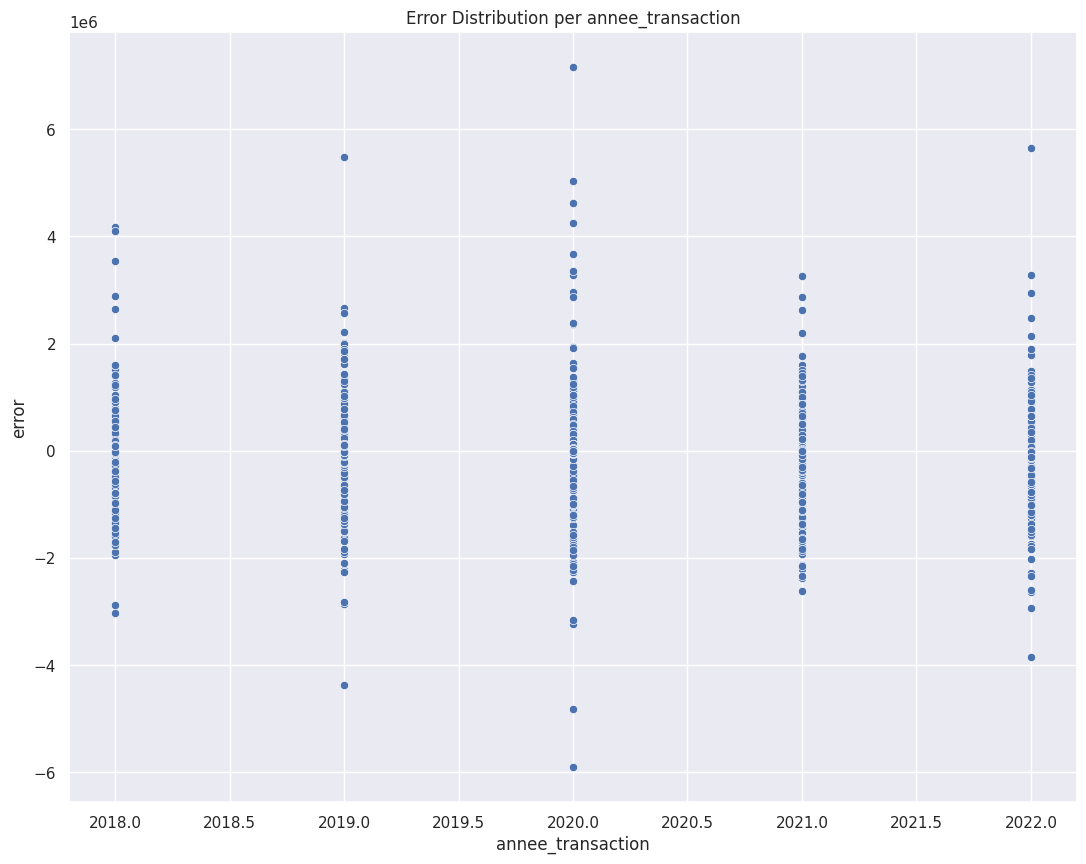

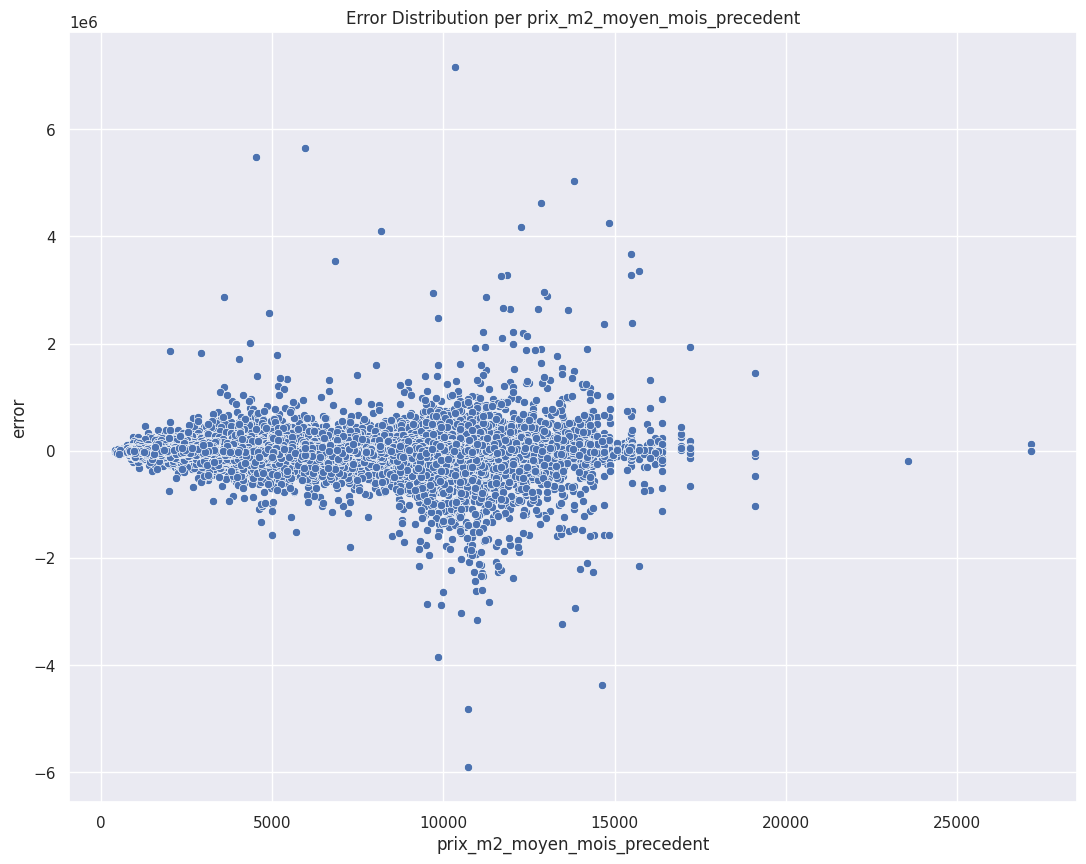

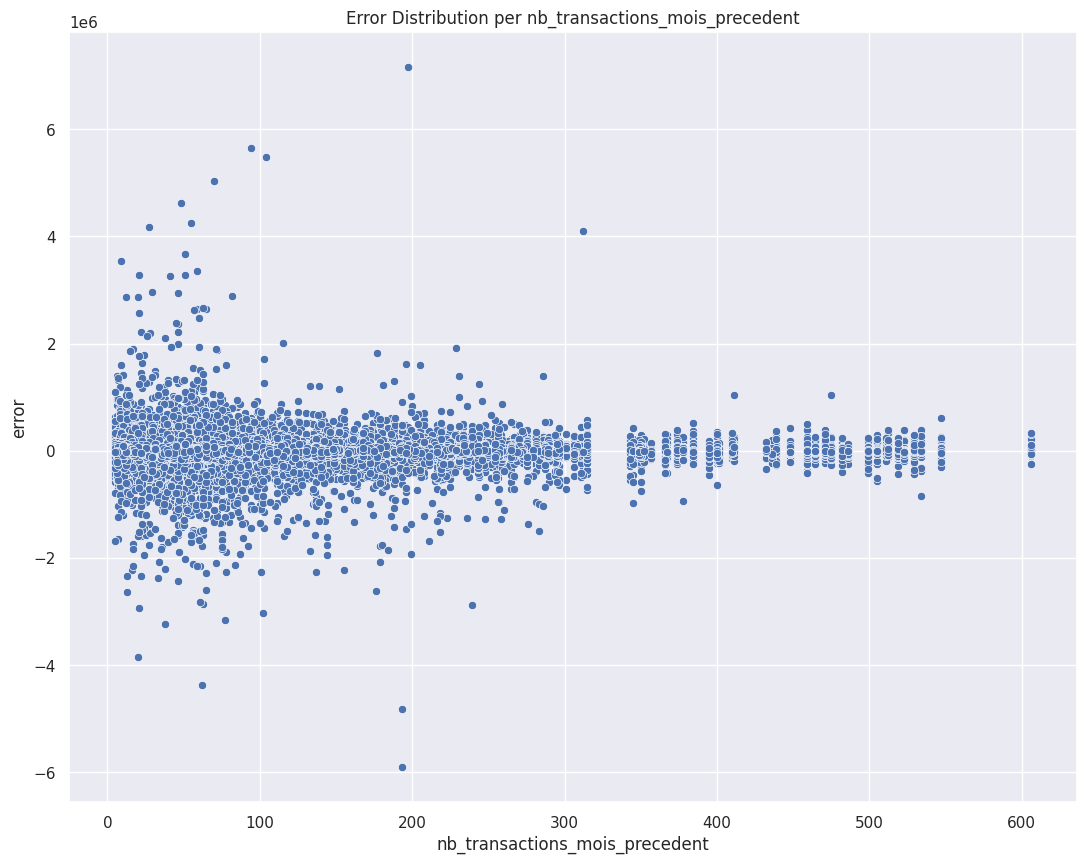

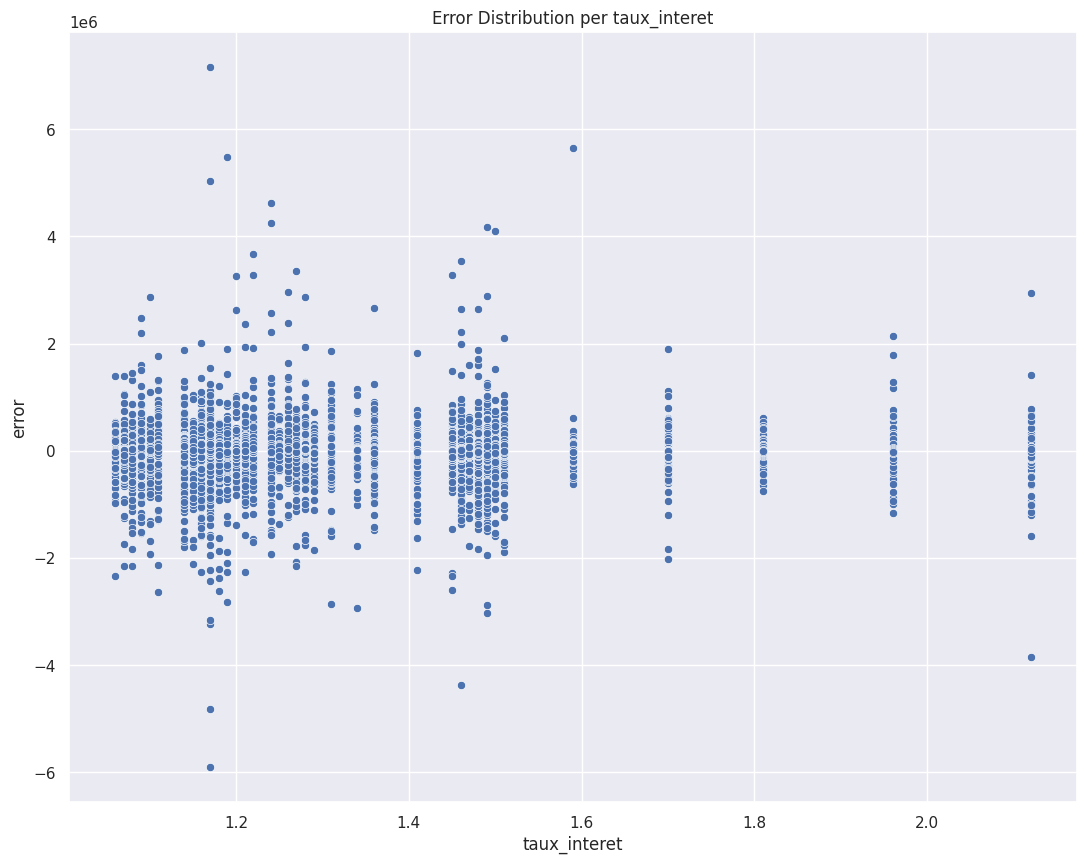

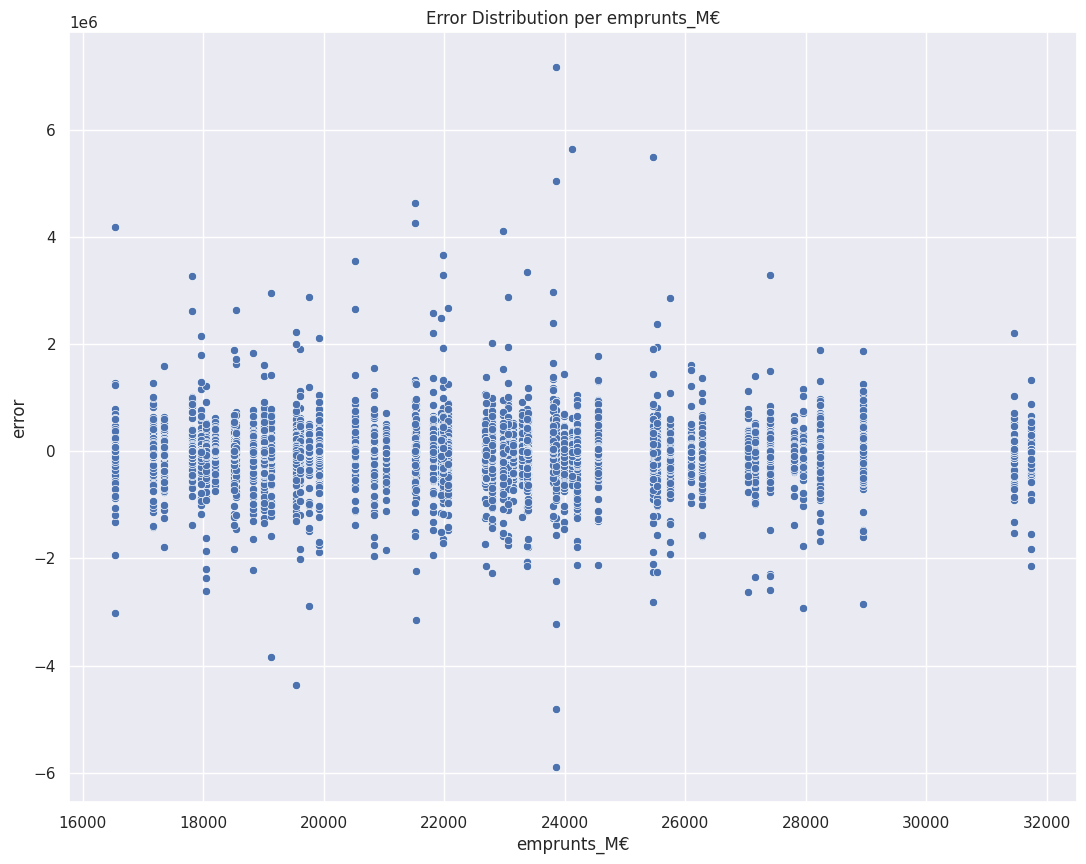

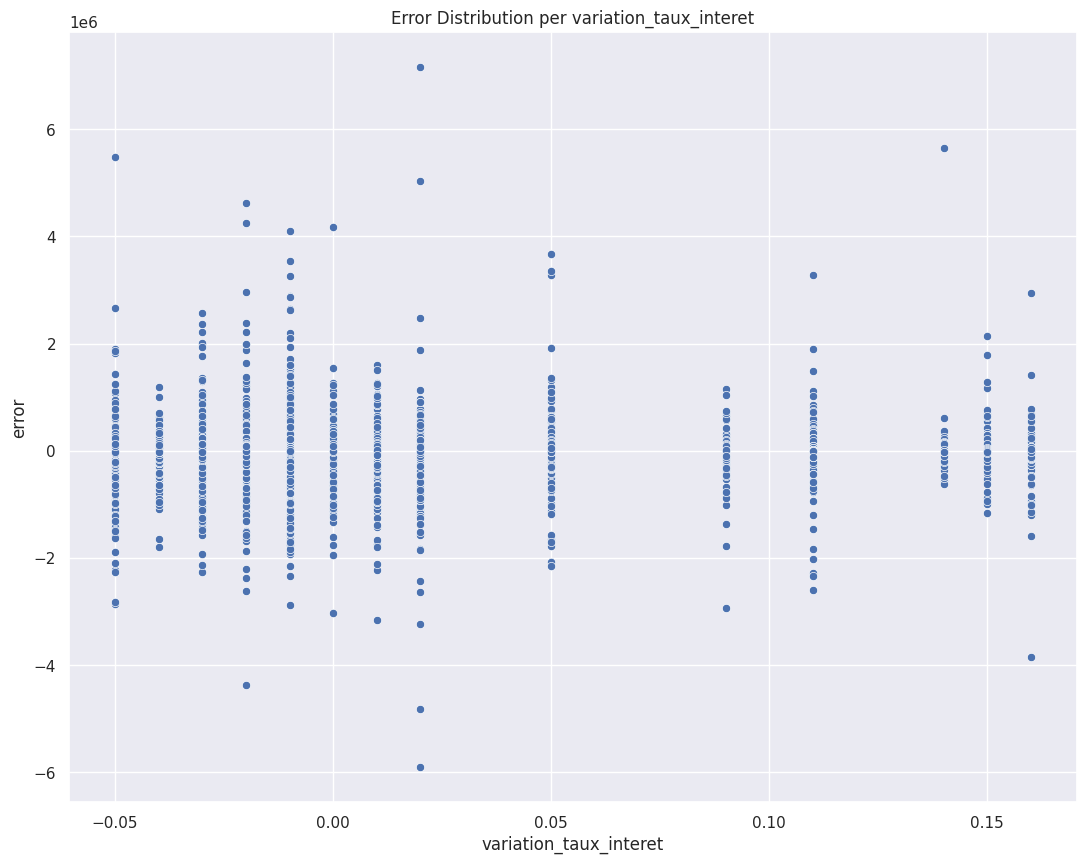

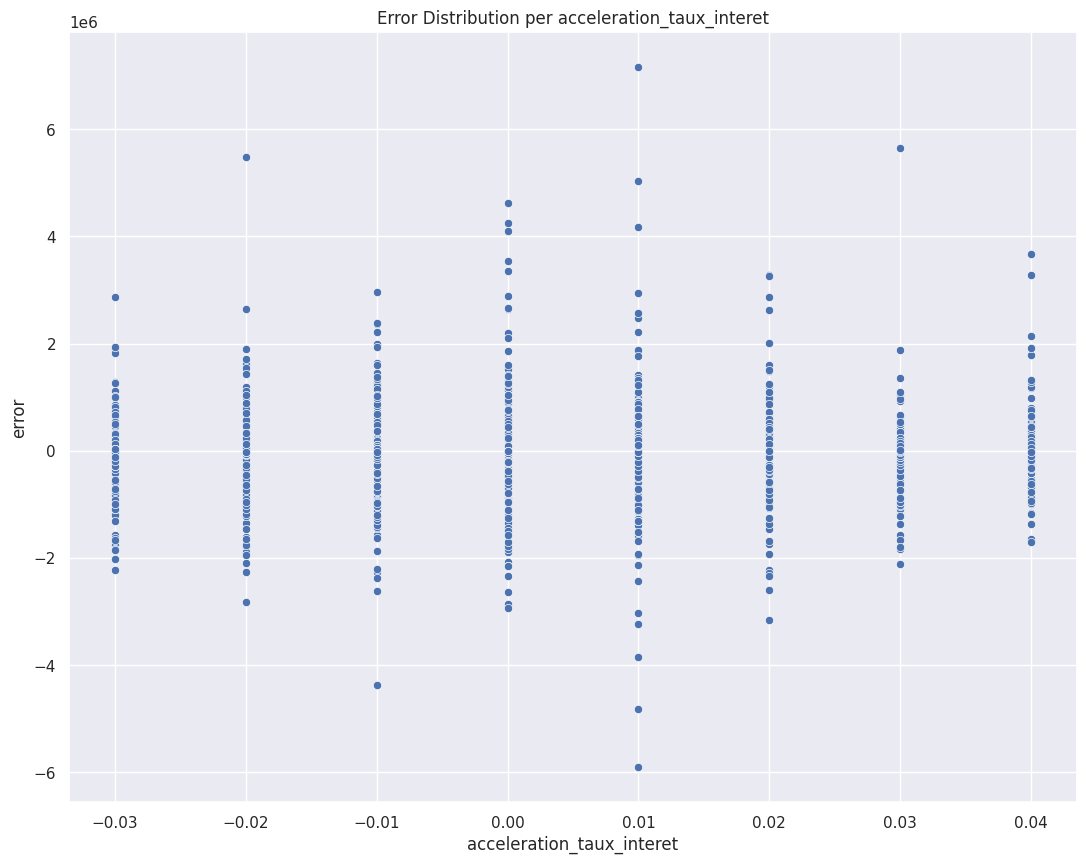

In [93]:
y_test_pred = catboost_regressor.predict(X_test[feature_names])
errors_test = y_test - y_test_pred
X_test["error"] = errors_test

for feature in numerical_features:
    plt.figure(figsize=(13, 10))
    sns.scatterplot(x=feature, y="error", data=X_test)
    plt.title("Error Distribution per {feature}".format(feature=feature))
    plt.show()

### Cas d'une classification

In [94]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import json
import os
import sys

In [95]:
import seaborn as sns

sns.set()
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from sklearn.ensemble import RandomForestClassifier

In [96]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_regression = transactions[REGRESSION_TARGET]
y_classification = transactions[CLASSIFICATION_TARGET]


with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)


numerical_features = [col for col in feature_names if col not in categorical_features]

In [97]:
classifier = RandomForestClassifier(random_state=random_state, verbose=False)

X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y_classification.to_pandas(), random_state=random_state
)

classifier.fit(X_train[feature_names], y_train)


RandomForestClassifier(random_state=42, verbose=False)

In [98]:
from sklearn.metrics import confusion_matrix, classification_report

y_train_pred = classifier.predict(X_train[feature_names])
y_test_pred = classifier.predict(X_test[feature_names])


confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
print(confusion_matrix_train)

classification_report_train = classification_report(y_train, y_train_pred)
print(classification_report_train)

confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix_test)

classification_report_test = classification_report(y_test, y_test_pred)
print(classification_report_test)

[[211642    601]
 [   876 123760]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212243
           1       1.00      0.99      0.99    124636

    accuracy                           1.00    336879
   macro avg       1.00      1.00      1.00    336879
weighted avg       1.00      1.00      1.00    336879

[[58012 12638]
 [22040 19603]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.77     70650
           1       0.61      0.47      0.53     41643

    accuracy                           0.69    112293
   macro avg       0.67      0.65      0.65    112293
weighted avg       0.68      0.69      0.68    112293



In [99]:
X_train["prediction"] = y_train_pred
X_train["probability_score"] = classifier.predict_proba(
    X_train[feature_names]
)[:, 1]

X_test["prediction"] = y_test_pred
X_test["probability_score"] = classifier.predict_proba(X_test[feature_names])[
    :, 1
]

In [100]:
def get_prediction_type(prediction, target):
    if prediction == 1 and target == 1:
        return "true_positive"
    elif prediction == 0 and target == 0:
        return "true_negative"
    elif prediction == 1 and target == 0:
        return "false_positive"
    elif prediction == 0 and target == 1:
        return "false_negative"
    else:
        return "unknown"

In [101]:
X_train[CLASSIFICATION_TARGET] = y_train
X_train["prediction_type"] = X_train.apply(
    lambda row: get_prediction_type(row["prediction"], row[CLASSIFICATION_TARGET]),
    axis=1,
)
X_test[CLASSIFICATION_TARGET] = y_test
X_test["prediction_type"] = X_test.apply(
    lambda row: get_prediction_type(row["prediction"], row[CLASSIFICATION_TARGET]),
    axis=1,
)

In [102]:
color_palette = {
    "true_positive": "green",
    "false_positive": "red",
    "false_negative": "orange",
    "true_negative": "blue"
    }
def plot_probability_distribution_per_prediction_type(
        X,
        color_palette,
        categories_to_excelude=["true_negative"]
    ):
    X_filtered = X[~X["prediction_type"].isin(categories_to_excelude)]
    sns.displot(data=X_filtered, x="probability_score", hue="prediction_type", palette=color_palette)
    plt.legend(loc="upper right")
    plt.show()


/tmp/ipython-input-905525515.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


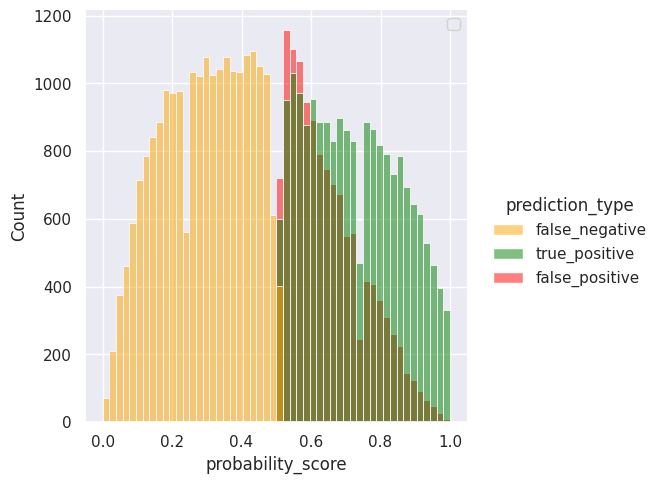

In [103]:
plot_probability_distribution_per_prediction_type(
    X_test,
    color_palette,
    categories_to_excelude=["true_negative"]
)

/tmp/ipython-input-905525515.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


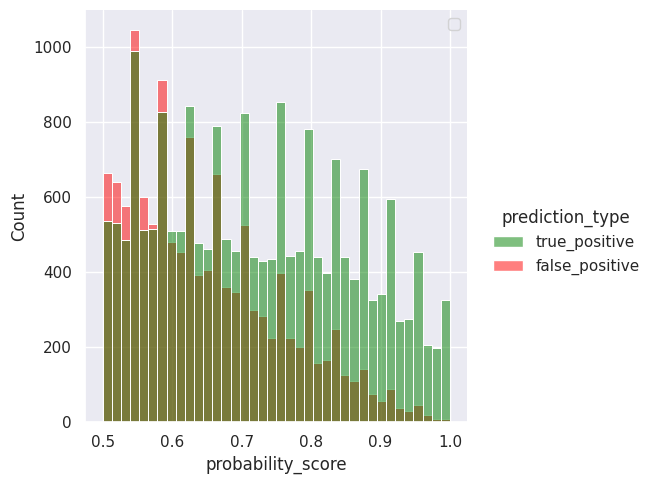

In [104]:
plot_probability_distribution_per_prediction_type(
    X_test,
    color_palette,
    categories_to_excelude=["true_negative", "false_negative"]
)

/tmp/ipython-input-905525515.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


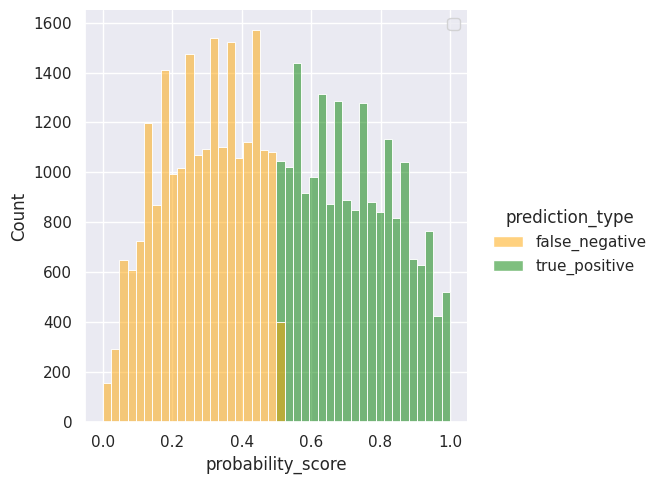

In [105]:
plot_probability_distribution_per_prediction_type(
    X_test,
    color_palette,
    categories_to_excelude=["true_negative", "false_positive"]
)

### la feature importance

In [106]:
import shap

In [107]:
from shap import (
    TreeExplainer,
    KernelExplainer,
    LinearExplainer,
    DeepExplainer,
    GradientExplainer
)

## deploiment d'un modéle

### avec BentoML

In [108]:
import polars as pl
import json
import os
import sys

sys.path.append("..")

from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)

from xgboost import XGBClassifier, XGBRegressor

# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
! pip install bentoml
import bentoml


In [109]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

In [110]:
X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET]).to_pandas()
y_regression = transactions[REGRESSION_TARGET].to_pandas()
y_classification = transactions[CLASSIFICATION_TARGET].to_pandas()

In [111]:
with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

In [112]:
numerical_features = [col for col in feature_names if col not in categorical_features]

In [113]:
xgb_regressor = XGBRegressor(random_state=random_state)
xgb_classifier = XGBClassifier(random_state=random_state)


In [114]:
xgb_regressor.fit(X[feature_names], y_regression)
xgb_classifier.fit(X[feature_names], y_classification)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [115]:
bentoml.sklearn.save_model("transaction_value_estimator", xgb_regressor)
bentoml.sklearn.save_model("transaction_below_market_identifier", xgb_classifier)

Model(tag="transaction_below_market_identifier:hnlu56eywsxyoasc", path="/tmp/bentoml-model-transaction_below_market_identifier-yncobh6_")

In [116]:
feature_names

['type_batiment_Appartement',
 'vefa',
 'surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'nom_region_Auvergne-Rhône-Alpes',
 'nom_region_Nouvelle-Aquitaine',
 'nom_region_Occitanie',
 "nom_region_Provence-Alpes-Côte d'Azur",
 'nom_region_Île-de-France',
 'ville_demandee',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent',
 'taux_interet',
 'emprunts_M€',
 'variation_taux_interet',
 'acceleration_taux_interet']

In [117]:
import numpy as np

test_values = np.array(
    [[list(X[feature].sample())[0] for feature in feature_names] for i in range(10)]
)

In [118]:
test_values

array([[ 1.00000000e+00,  0.00000000e+00,  4.90000000e+01,
         4.32955091e+01,  2.31997423e+00,  1.10000000e+01,
         2.02200000e+03,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  4.18548094e+03,  4.30000000e+01,
         2.12000000e+00,  2.54620000e+04,  2.00000000e-02,
         1.00000000e-02],
       [ 1.00000000e+00,  0.00000000e+00,  6.80000000e+01,
         4.36001148e+01,  2.28944868e+00,  5.00000000e+00,
         2.01800000e+03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  2.22489009e+03,  2.00000000e+01,
         1.28000000e+00,  1.99280000e+04,  1.40000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.90000000e+01,
         4.49952750e+01,  6.23366797e+00,  3.00000000e+00,
         2.01800000e+03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
    

In [119]:
with bentoml.SyncHTTPClient("http://localhost:3000") as client:
    result = client.predict(transactions=test_values)

ServiceUnavailable: Server is not ready after 30 seconds

In [ ]:
result[0]


cas2 car la premiére methode ne marche pas


In [120]:
# CORRECTION 1: Utiliser bentoml.xgboost au lieu de bentoml.sklearn
regression_model = bentoml.xgboost.save_model(
    "transaction_value_estimator",
    xgb_regressor,
    labels={
        "owner": "data_scientist",
        "framework": "xgboost",
        "task": "regression",
        "target": REGRESSION_TARGET
    },
    metadata={
        "feature_names": feature_names,
        "categorical_features": categorical_features,
        "numerical_features": numerical_features,
        "n_features": len(feature_names)
    }
)

In [121]:
classification_model = bentoml.xgboost.save_model(
    "transaction_below_market_identifier",
    xgb_classifier,
    labels={
        "owner": "data_scientist",
        "framework": "xgboost",
        "task": "classification",
        "target": CLASSIFICATION_TARGET
    },
    metadata={
        "feature_names": feature_names,
        "categorical_features": categorical_features,
        "numerical_features": numerical_features,
        "n_features": len(feature_names)
    }
)

In [123]:
print(f"Modèle de régression sauvegardé: {regression_model.tag}")
print(f"Modèle de classification sauvegardé: {classification_model.tag}")


Modèle de régression sauvegardé: transaction_value_estimator:l2ipzleywsxyoasc
Modèle de classification sauvegardé: transaction_below_market_identifier:ma6pvceywsxyoasc


In [124]:
print("Sauvegarde des métadonnées...")


Sauvegarde des métadonnées...


In [125]:
# Sauvegarder les feature_names pour le service BentoML
with open("feature_metadata.json", "w") as f:
    json.dump({
        "feature_names": feature_names,
        "categorical_features": categorical_features,
        "numerical_features": numerical_features
    }, f, indent=2)

In [126]:
print("Features utilisées:", len(feature_names))
print("Features catégorielles:", len(categorical_features))
print("Features numériques:", len(numerical_features))

Features utilisées: 19
Features catégorielles: 9
Features numériques: 11


In [127]:
print("Génération de données de test...")

Génération de données de test...


In [128]:
# CORRECTION 2: Génération correcte des données de test
def generate_test_data(X_df, feature_names, n_samples=10):
    """Génère des données de test réalistes"""
    test_data = []

    # Prendre un échantillon aléatoire du dataset existant
    sample_indices = np.random.choice(len(X_df), n_samples, replace=False)

    for idx in sample_indices:
        sample_dict = {}
        for feature in feature_names:
            if feature in X_df.columns:
                sample_dict[feature] = float(X_df.iloc[idx][feature])
            else:
                # Valeur par défaut si la feature n'existe pas
                sample_dict[feature] = 0.0
        test_data.append(sample_dict)

    return test_data

test_samples = generate_test_data(X, feature_names, n_samples=5)

In [129]:
print("Exemples de données de test générées:")
for i, sample in enumerate(test_samples[:2]):
    print(f"\nÉchantillon {i+1}:")
    print(f"  - surface_habitable: {sample.get('surface_habitable', 'N/A')}")
    print(f"  - nb_transactions_mois_precedent: {sample.get('nb_transactions_mois_precedent', 'N/A')}")
    print(f"  - vefa: {sample.get('vefa', 'N/A')}")
    print(f"  - ville_demandee: {sample.get('ville_demandee', 'N/A')}")


Exemples de données de test générées:

Échantillon 1:
  - surface_habitable: 23.0
  - nb_transactions_mois_precedent: 523.0
  - vefa: 0.0
  - ville_demandee: 1.0

Échantillon 2:
  - surface_habitable: 22.0
  - nb_transactions_mois_precedent: 6.0
  - vefa: 0.0
  - ville_demandee: 0.0


avec chat

In [130]:
!pip install bentoml scikit-learn xgboost polars


In [131]:
import polars as pl
import json
import os
import sys
from xgboost import XGBClassifier, XGBRegressor
import bentoml

sys.path.append("..")

from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)

# Charger les données
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET]).to_pandas()
y_regression = transactions[REGRESSION_TARGET].to_pandas()
y_classification = transactions[CLASSIFICATION_TARGET].to_pandas()

# Charger les features utilisées
with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]

# Entraînement
xgb_regressor = XGBRegressor(random_state=random_state)
xgb_classifier = XGBClassifier(random_state=random_state)

xgb_regressor.fit(X[feature_names], y_regression)
xgb_classifier.fit(X[feature_names], y_classification)

# Sauvegarde dans BentoML (⚠️ avec le bon module xgboost)
bentoml.xgboost.save_model("transaction_value_estimator", xgb_regressor)
bentoml.xgboost.save_model("transaction_below_market_identifier", xgb_classifier)


Model(tag="transaction_below_market_identifier:q26rhfuywsxyoasc", path="/tmp/bentoml-model-transaction_below_market_identifier-43oyx0ub")

In [132]:
%%writefile service.py
import bentoml
import numpy as np
from bentoml.io import NumpyNdarray

# Charger les modèles sauvegardés
regressor_runner = bentoml.xgboost.get("transaction_value_estimator:latest").to_runner()
classifier_runner = bentoml.xgboost.get("transaction_below_market_identifier:latest").to_runner()

# Définir le service
svc = bentoml.Service("transaction_predictor", runners=[regressor_runner, classifier_runner])

# Endpoint pour prédire la valeur
@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
async def predict_value(input_array: np.ndarray):
    return await regressor_runner.predict.async_run(input_array)

# Endpoint pour identifier si en-dessous du marché
@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
async def predict_below_market(input_array: np.ndarray):
    return await classifier_runner.predict.async_run(input_array)


Overwriting service.py


In [133]:
# verifier si le fichier existe
!ls -l service.py

-rw-r--r-- 1 root root 846 Sep 23 19:35 service.py


In [134]:
!bentoml serve service.py:svc --port 3000 &

/usr/local/lib/python3.12/dist-packages/bentoml/io.py:7: BentoMLDeprecationWarning: `bentoml.io` is deprecated since BentoML v1.4 and will be removed in a future version. Please upgrade to new style IO types instead.
  warn_deprecated(
/usr/local/lib/python3.12/dist-packages/bentoml/_internal/models/model.py:353: BentoMLDeprecationWarning: `get_runnable` is deprecated since BentoML v1.4 and will be removed in a future version. Use `get_service` instead.
  self._runnable = self.info.imported_module.get_runnable(self)
/usr/local/lib/python3.12/dist-packages/bentoml/_internal/models/model.py:340: BentoMLDeprecationWarning: `Runner` is deprecated since BentoML v1.4 and will be removed in a future version. Please upgrade to new style services.
  return Runner(
Traceback (most recent call last):
  File "/usr/local/bin/bentoml", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1442, in __call__
    return self.main

Problème : Colab n’autorise pas d’accéder directement à localhost:3000.
➡️ Il faut utiliser ngrok pour exposer ton service :

In [135]:
!pip install pyngrok
from pyngrok import ngrok
!ngrok config add-authtoken TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [136]:
# Lancer BentoML en arrière-plan
get_ipython().system_raw("bentoml serve service.py:svc --port 3000 &")

# Créer un tunnel vers le port 3000
public_url = ngrok.connect(3000)
print("Ton service est accessible ici :", public_url)

ERROR:pyngrok.process.ngrok:t=2025-09-23T19:36:19+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-23T19:36:19+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [ ]:
!ngrok config add-authtoken 335yM38DfraWgaiMFMpMTjlLM0y_PhUNXCLgws3Eajhks2Rs

In [137]:
# Lancer BentoML en arrière-plan
get_ipython().system_raw("bentoml serve service.py:svc --port 3000 &")

# Créer un tunnel vers le port 3000
public_url = ngrok.connect(3000)
print("Ton service est accessible ici :", public_url)

ERROR:pyngrok.process.ngrok:t=2025-09-23T19:53:53+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-23T19:53:53+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: TPXRXBGUW3T7D5GLQYV6OQJUFKQ6SF24\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [139]:
# Pour un usage basique sans token (mais limité en temps)
from pyngrok import ngrok

# Démarrer BentoML
get_ipython().system_raw("bentoml serve service.py:svc --port 3000 &")
time.sleep(10)

# Créer un tunnel sans authentification (fonctionne pour des sessions courtes)
public_url = ngrok.connect(3000, bind_tls=True)
print("Ton service est accessible ici :", public_url)

NameError: name 'time' is not defined

In [141]:
!pip uninstall evidently pydantic -y
!pip install "pydantic>=2.0.0" "evidently>=0.4.0"

# Vérification
import pydantic
print(f"Pydantic version: {pydantic.__version__}")

# Test de l'import
try:
    from evidently.pipeline.column_mapping import ColumnMapping
    print("✅ Import réussi !")
except ImportError as e:
    print(f"❌ Erreur: {e}")

Found existing installation: evidently 0.7.14
Uninstalling evidently-0.7.14:
  Successfully uninstalled evidently-0.7.14
Found existing installation: pydantic 2.11.9
Uninstalling pydantic-2.11.9:
  Successfully uninstalled pydantic-2.11.9
  Using cached pydantic-2.11.9-py3-none-any.whl.metadata (68 kB)
  Using cached evidently-0.7.14-py3-none-any.whl.metadata (11 kB)
Using cached pydantic-2.11.9-py3-none-any.whl (444 kB)
Using cached evidently-0.7.14-py3-none-any.whl (4.3 MB)


Pydantic version: 2.11.9
❌ Erreur: No module named 'evidently.pipeline'


In [142]:
import numpy as np
from bentoml import SyncHTTPClient

client = SyncHTTPClient(public_url)  # URL ngrok
X_test = np.random.rand(2, len(feature_names))  # exemples factices

print("Valeur estimée :", client.predict_value(X_test))
print("Sous le marché :", client.predict_below_market(X_test))


ServiceUnavailable: Server is not ready after 30 seconds

In [140]:
import numpy as np
import requests
from bentoml import SyncHTTPClient
import json

public_url = "https://unnocturnal-nondenunciative-grey.ngrok-free.dev"  # Remplacez par votre URL

def test_api_connection():
    try:
        # Vérification de la connexion
        client = SyncHTTPClient(public_url)

        # Test health endpoint
        health = client.health()
        print("✅ Serveur en ligne")

        # Préparation des données
        feature_names = ['feature1', 'feature2', 'feature3']  # Adaptez selon votre modèle
        X_test = np.random.rand(2, len(feature_names)).tolist()  # Conversion en liste

        # Test prediction
        print("Envoi des données...")
        print("Données envoyées:", json.dumps(X_test, indent=2))

        # Appel des endpoints
        valeur_estimee = client.predict_value(X_test)
        sous_marche = client.predict_below_market(X_test)

        print("✅ Valeur estimée :", valeur_estimee)
        print("✅ Sous le marché :", sous_marche)

    except Exception as e:
        print(f"❌ Erreur: {e}")
        print("Vérifiez que:")
        print("1. Votre serveur BentoML est bien démarré")
        print("2. L'URL ngrok est correcte")
        print("3. Les endpoints existent bien")

# Exécution du test
test_api_connection()

❌ Erreur: Server is not ready after 30 seconds
Vérifiez que:
1. Votre serveur BentoML est bien démarré
2. L'URL ngrok est correcte
3. Les endpoints existent bien


In [ ]:
# Exécution du test
test_api_connection()

In [ ]:
import bentoml
from bentoml.io import NumpyNdarray, JSON
import numpy as np

@bentoml.service(
    resources={"cpu": "1"},
    traffic={"timeout": 10},
)
class HousePriceService:

    def __init__(self):
        # Modèle factice pour l'exemple
        self.market_price = 500000

    @bentoml.api(input=NumpyNdarray(), output=JSON())
    def predict_value(self, input_data: np.ndarray) -> dict:
        """Prédit la valeur estimée (exemple factice)"""
        try:
            # Simulation de prédiction - moyenne des features * 100000
            predicted_value = float(np.mean(input_data) * 100000)
            return {
                "predicted_value": predicted_value,
                "status": "success"
            }
        except Exception as e:
            return {"error": str(e), "status": "error"}

    @bentoml.api(input=NumpyNdarray(), output=JSON())
    def predict_below_market(self, input_data: np.ndarray) -> dict:
        """Détermine si c'est sous le marché"""
        try:
            predicted_value = float(np.mean(input_data) * 100000)
            is_below = predicted_value < self.market_price

            return {
                "below_market": is_below,
                "predicted_value": predicted_value,
                "market_price": self.market_price,
                "status": "success"
            }
        except Exception as e:
            return {"error": str(e), "status": "error"}

In [ ]:
# Dans votre service BentoML
@svc.api(input=NumpyNdarray(), output=JSON())
def predict_value(input_data):
    # Votre logique
    pass

@svc.api(input=NumpyNdarray(), output=JSON())
def predict_below_market(input_data):
    # Votre logique
    pass

In [ ]:
import numpy as np
from bentoml import SyncHTTPClient

# ⚠️ Remplace par ton URL ngrok
public_url = "https://unnocturnal-nondenunciative-grey.ngrok-free.dev"

client = SyncHTTPClient(public_url)

# Exemple de données factices (adapter la taille à ton modèle !)
X_test = np.random.rand(2, len(feature_names))  # 2 lignes, autant de colonnes que tes features

print("Valeur estimée :", client.predict_value(X_test))
print("Sous le marché :", client.predict_below_market(X_test))


### détecter la drift d'un model

Nous donnons ici comme exemple un test pour les features quantitatives dans un jeu de données de petite taille (quelques milliers de lignes au maximum), il s’agit du test de Kolmogorov-Smirnov, ou KS test pour faire court :
* C’est un test qui peut déterminer si la distribution de votre feature quantitative est similaire à une autre, qu’elle soit théorique (comme la loi Gaussienne) ou empirique, comme la distribution d’une autre feature.  
On peut donc clairement l’utiliser pour comparer la distribution d’une feature quantitative à l’instant t avec la distribution de la même feature à un instant t + quelques jours/semaines/mois, en fonction de la vitesse avec laquelle la donnée évolue.

Dois-je connaître alors toutes les mesures de drift en fonction de la taille du jeu de données et de la nature des features ?

Plus vous en connaissez, le mieux c'est ! Toutefois, il existe un package assez pratique et de plus en plus populaire qui nous aide à automatiser la détection de drift, y compris le choix de la technique de mesure ! Découvrons ensemble le package Evidently :

In [143]:
import pandas as pd
import json
import os
import sys

sys.path.append("..")
from settings import PROJECT_PATH, CLASSIFICATION_TARGET, REGRESSION_TARGET

In [144]:
transactions = pd.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

transactions_extra_info = pd.read_parquet("/content/transactions_extra_infos.parquet")

with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]

Afin de séparer la donnée en covid et post-covid, nous avons besoin de la date de transaction. Cette information se trouve dans le jeu de données transactions_extra_infos. Une jointure est alors nécessaire.

In [145]:
transactions = transactions.merge(
    transactions_extra_info[["id_transaction", "date_transaction"]],
    on="id_transaction",
    how="left",
)

transactions["anne_mois"] = transactions["date_transaction"].dt.to_period("M")

In [146]:
transactions_pre_covid = transactions[transactions["anne_mois"] < "2020-03"]

transactions_covid = transactions[
    transactions["anne_mois"].between("2020-03", "2021-07")
]
transactions_post_covid = transactions[transactions["anne_mois"] > "2021-07"]

On commence par la classification

In [147]:
# D'abord, désinstaller toute version existante




In [148]:
# Installer une version compatible
!pip install evidently==0.4.0

  Using cached evidently-0.4.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached pydantic-1.10.23-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (154 kB)
Using cached evidently-0.4.0-py3-none-any.whl (5.3 MB)
Using cached pydantic-1.10.23-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.8 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.9
    Uninstalling pydantic-2.11.9:
      Successfully uninstalled pydantic-2.11.9
  Attempting uninstall: evidently
    Found existing installation: evidently 0.7.14
    Uninstalling evidently-0.7.14:
      Successfully uninstalled evidently-0.7.14
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.76 requires pydantic>=2.7.4, but you have pydantic 1.10.23 which is incompatible.
albumentations 2.0.8 requires pydantic>=2.9.2, but you have pydant

In [149]:
from evidently.pipeline.column_mapping import ColumnMapping

In [150]:
from evidently import ColumnMapping
from evidently.metric_preset import TargetDriftPreset
from evidently.report import Report

ImportError: cannot import name 'ColumnMapping' from 'evidently' (/usr/local/lib/python3.12/dist-packages/evidently/__init__.py)

La procédure est très similaire à celle du Data Drift. On commence par définir un objet ColumnMapping

In [151]:
column_mapping = ColumnMapping()

column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features
column_mapping.target = CLASSIFICATION_TARGET
column_mapping.datetime = "annee_mois"
column_mapping.prediction = "prediction"

In [152]:
target_drift_report = Report(metrics=[TargetDriftPreset()])

target_drift_report.run(
    reference_data=transactions_covid,
    current_data=transactions_post_covid,
    column_mapping=column_mapping,
)

NameError: name 'Report' is not defined

In [153]:
target_drift_report

NameError: name 'target_drift_report' is not defined

Selon Evidently, il n'y a pas de drift significatif de la target de classification. Nous pouvons voir que la mesure utilisée est celle de Jensen-Shannon. Ensuite, une corrélation de Cramer V a été utilisée. Il s'agit d'un coefficient de corrélation entre les features qualitatives, se basant sur le principe du test du Khi 2. Dans l'ensemble, chaque feature est moins corrélé à la cible qu'avant. Ceci peut être indicatif d'un changement à venir dans la relation entre les features et la cible (et donc la performance du modèle). Toutefois, nous n'avons pas assez d'éléments pour confirmer un drift.

Puis pour la regression  
Nous réutilisons la même approche

In [154]:
column_mapping = ColumnMapping()

column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features
column_mapping.target = REGRESSION_TARGET
column_mapping.id = "id_transaction"
column_mapping.datetime = "date_transaction"
column_mapping.prediction = "prediction"

In [155]:
target_drift_report = Report(metrics=[TargetDriftPreset()])

target_drift_report.run(
    reference_data=transactions_covid,
    current_data=transactions_post_covid,
    column_mapping=column_mapping,
)

NameError: name 'Report' is not defined

In [156]:
target_drift_report

NameError: name 'target_drift_report' is not defined

Concernant le premier visuel, l'onglet Data Distribution est plus parlant que l'onglet Data Drift, sans être très informateur. En effet, il semble y avoir un changement dans la distribution, mais on ne peut pas l'affirmer avec certitude : Le jeu de données post-covid (ou "current") est beaucoup moins peuplé et l'histograme compresse la distribution vu le nombre très faible de bins, ce qui peut cacher des subtilités.

Le deuxième graphique est plus intéressant, on y vois l'evolution de la moyenne de la target (trait central) ainsi qu'une dispersion de la moyenne de l'ordre d'un ecart-type (surface colorée autour du point central). Même si la moyenne pendant la période post-covid est légèrement plus basse, nous ne pouvons pas observer un drift global. Ceci dit, il faudrait creuser en réalisant la même analyse région par région, où les résultats pourraient être très différents.

In [170]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import numpy as np
import json
import os
import sys

sys.path.append("..")

import seaborn as sns

sns.set()
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import mlflow
from tqdm import tqdm

In [171]:
def perform_cross_validation(
    X: pl.DataFrame,
    y: pl.Series,
    model,
    cross_val_type,
    scoring_metrics: tuple,
    groups=None,
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=True,
        scoring=scoring_metrics,
        groups=groups,
    )

    scores_dict = {}
    for metric in scoring_metrics:
        scores_dict["average_train_" + metric] = np.mean(scores["train_" + metric])
        scores_dict["train_" + metric + "_std"] = np.std(scores["train_" + metric])
        scores_dict["average_test_" + metric] = np.mean(scores["test_" + metric])
        scores_dict["test_" + metric + "_std"] = np.std(scores["test_" + metric])

    model.fit(X.to_numpy(), y.to_numpy())

    return scores, scores_dict, model


In [172]:
def get_features_most_importance(importances, feature_names, threshold=0.8):
    sorted_indices = np.argsort(importances)
    sorted_importances = importances[sorted_indices][::-1]
    sorted_feature_names = [feature_names[i] for i in sorted_indices][::-1]

    cumulated_importance = 0
    important_features = []

    for importance, feature_name in zip(sorted_importances, sorted_feature_names):
        cumulated_importance += importance
        important_features.append(feature_name)

        if cumulated_importance >= threshold:
            break

    return important_features



In [176]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)

with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]


In [177]:
feature_names

['type_batiment_Appartement',
 'vefa',
 'surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'nom_region_Auvergne-Rhône-Alpes',
 'nom_region_Nouvelle-Aquitaine',
 'nom_region_Occitanie',
 "nom_region_Provence-Alpes-Côte d'Azur",
 'nom_region_Île-de-France',
 'ville_demandee',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent',
 'taux_interet',
 'emprunts_M€',
 'variation_taux_interet',
 'acceleration_taux_interet']

In [178]:
transactions_v1 = transactions.filter(pl.col("annee_transaction") < 2020)

transactions_v2 = transactions.filter(
    pl.col("annee_transaction").is_between(2020, 2021)
)
features_1 = [
    "type_batiment_Appartement",
    "surface_habitable",
    "prix_m2_moyen_mois_precedent",
    "nb_transactions_mois_precedent",
    "taux_interet",
    "variation_taux_interet",
    "acceleration_taux_interet",
]

features_2 = features_1.extend(["longitude", "latitude", "vefa"])


In [179]:
from mlflow import MlflowClient

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [180]:
mlflow.search_runs(search_all_experiments=True)

,run_id,experiment_id,status,artifact_uri,start_time,end_time


In [181]:
for region in tqdm(
    [
        "Île-de-France",
        "Auvergne-Rhône-Alpes",
        "Nouvelle-Aquitaine",
    ]
):
    region_transactions_v1 = transactions_v1.filter(pl.col("nom_region_" + region) == 1)

    experiment_tags = {
        "region": region,
        "revision_de_donnees": "v1",
        "date_de_construction": "Fin 2019",
    }

    try:
        region_experiment = client.create_experiment(region, tags=experiment_tags)
    except:
        region_experiment = mlflow.set_experiment(region)

    # ------------------------ 1er Run Modèle Dummy  ----------------
    with mlflow.start_run(run_name="dummy_run_" + region) as run:
        print(
            " ------------------Running Dummy Model for Region: ",
            region + "------------------",
        )
        X = region_transactions_v1.drop(
            [REGRESSION_TARGET, CLASSIFICATION_TARGET]
        ).to_pandas()
        y_classification = region_transactions_v1[CLASSIFICATION_TARGET].to_pandas()

        dummy_classifier = DummyClassifier(strategy="most_frequent")
        classification_scoring_metrics = ["recall", "precision", "f1"]

        scores, scores_dict, dummy_classifier = perform_cross_validation(
            X=X[features_1],
            y=y_classification,
            model=dummy_classifier,
            cross_val_type=StratifiedKFold(),
            scoring_metrics=classification_scoring_metrics,
        )

        mlflow.log_param("random_state", random_state)
        mlflow.log_param("features", features_1)

        mlflow.log_metrics(scores_dict)

        mlflow.sklearn.log_model(dummy_classifier, "dummy_classifier")

        dataset_abstraction = mlflow.data.from_pandas(
            region_transactions_v1.to_pandas()
        )
        mlflow.log_input(dataset_abstraction)

  0%|          | 0/3 [00:00<?, ?it/s]2025/09/23 20:27:46 INFO mlflow.tracking.fluent: Experiment with name 'Île-de-France' does not exist. Creating a new experiment.


 ------------------Running Dummy Model for Region:  Île-de-France------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

 ------------------Running Dummy Model for Region:  Auvergne-Rhône-Alpes------------------


2025/09/23 20:28:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
 67%|██████▋   | 2/3 [00:22<00:10, 10.34s/it]2025/09

 ------------------Running Dummy Model for Region:  Nouvelle-Aquitaine------------------


2025/09/23 20:28:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
100%|██████████| 3/3 [00:28<00:00,  9.45s/it]


In [183]:

    with mlflow.start_run(run_name="catboost_" + region) as run:
        print(
            " ------------------Running Catboost Model for Region: ",
            region + "------------------",
        )
        X = region_transactions_v1.drop(
            [REGRESSION_TARGET, CLASSIFICATION_TARGET]
        ).to_pandas()
        y_classification = region_transactions_v1[CLASSIFICATION_TARGET].to_pandas()

        catboost_model = CatBoostClassifier(random_state=random_state, verbose=False)
        classification_scoring_metrics = ["recall", "precision", "f1"]

        scores, scores_dict, catboost_model = perform_cross_validation(
            X=X[features_1],
            y=y_classification,
            model=catboost_model,
            cross_val_type=StratifiedKFold(),
            scoring_metrics=classification_scoring_metrics,
        )

        mlflow.log_param("random_state", random_state)
        mlflow.log_param("features", features_1)

        for metric, value in scores_dict.items():
            mlflow.log_metric(metric, value)

        mlflow.sklearn.log_model(catboost_model, "catboost_classifier")

        dataset_abstraction = mlflow.data.from_pandas(
            region_transactions_v1.to_pandas()
        )
        mlflow.log_input(dataset_abstraction)

    feature_importances = catboost_model.get_feature_importance(Pool(X[features_1]))
    most_important_features = get_features_most_importance(
        feature_importances, features_1
    )

 ------------------Running Catboost Model for Region:  Nouvelle-Aquitaine------------------


2025/09/23 20:30:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/23 20:30:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-wit

In [184]:
with mlflow.start_run(run_name="catboost_light_" + region) as run:
        print(
            " ------------------Running Catboost Light Model for Region: ",
            region + "------------------",
        )
        X = region_transactions_v1.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
        y_classification = region_transactions_v1[CLASSIFICATION_TARGET]

        catboost_light_model = CatBoostClassifier(
            random_state=random_state, verbose=False
        )
        classification_scoring_metrics = ["recall", "precision", "f1"]

        scores, scores_dict, catboost_light_model = perform_cross_validation(
            X=X[most_important_features],
            y=y_classification,
            model=catboost_light_model,
            cross_val_type=StratifiedKFold(),
            scoring_metrics=classification_scoring_metrics,
        )

        mlflow.log_param("random_state", random_state)
        mlflow.log_param("features", most_important_features)

        for metric, value in scores_dict.items():
            mlflow.log_metric(metric, value)

        mlflow.sklearn.log_model(catboost_light_model, "catboost_light_classifier")

        dataset_abstraction = mlflow.data.from_pandas(
            region_transactions_v1.to_pandas()
        )
        mlflow.log_input(dataset_abstraction)


 ------------------Running Catboost Light Model for Region:  Nouvelle-Aquitaine------------------


2025/09/23 20:31:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/23 20:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-wit

In [192]:
nouvelle_acquitaine_experiment = client.set_experiment("Nouvelle-Aquitaine")

client = mlflow.tracking.MlflowClient()



with mlflow.start_run(run_name="catboost_" + region) as run:
        print(
            " ------------------Running Catboost Model for Region: ",
            region + "------------------",
        )
        X = region_transactions_v1.drop(
            [REGRESSION_TARGET, CLASSIFICATION_TARGET]
        ).to_pandas()
        y_classification = region_transactions_v1[CLASSIFICATION_TARGET].to_pandas()

        catboost_model = CatBoostClassifier(random_state=random_state, verbose=False)
        classification_scoring_metrics = ["recall", "precision", "f1"]

        scores, scores_dict, catboost_model = perform_cross_validation(
            X=X[features_1],
            y=y_classification,
            model=catboost_model,
            cross_val_type=StratifiedKFold(),
            scoring_metrics=classification_scoring_metrics,
        )

        mlflow.log_param("random_state", random_state)
        mlflow.log_param("features", features_1)

        for metric, value in scores_dict.items():
            mlflow.log_metric(metric, value)

        mlflow.sklearn.log_model(catboost_model, "catboost_classifier")

        dataset_abstraction = mlflow.data.from_pandas(
            region_transactions_v1.to_pandas()
        )
        mlflow.log_input(dataset_abstraction)

    feature_importances = catboost_model.get_feature_importance(Pool(X[features_1]))
    most_important_features  = get_features_most_importance(
        feature_importances, features_1
    )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 41)

In [158]:
!pip install mlflow

  Using cached pydantic-2.11.9-py3-none-any.whl.metadata (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.5/717.5 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.7 M

In [157]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np
import json
import os
import sys


import seaborn as sns

from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score
import mlflow
from mlflow import MlflowClient

ModuleNotFoundError: No module named 'mlflow'

In [168]:
mlflow.__version__

NameError: name 'mlflow' is not defined

In [159]:
def perform_cross_validation(
    X: pl.DataFrame,
    y: pl.Series,
    model,
    cross_val_type,
    scoring_metrics: tuple,
    groups=None,
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=True,
        scoring=scoring_metrics,
        groups=groups,
    )

    scores_dict = {}
    for metric in scoring_metrics:
        scores_dict["average_train_" + metric] = np.mean(scores["train_" + metric])
        scores_dict["train_" + metric + "_std"] = np.std(scores["train_" + metric])
        scores_dict["average_test_" + metric] = np.mean(scores["test_" + metric])
        scores_dict["test_" + metric + "_std"] = np.std(scores["test_" + metric])

    model.fit(X.to_numpy(), y.to_numpy())

    return scores, scores_dict, model

def get_features_most_importance(importances, feature_names, threshold=0.8):
    sorted_indices = np.argsort(importances)
    sorted_importances = importances[sorted_indices][::-1]
    sorted_feature_names = [feature_names[i] for i in sorted_indices][::-1]

    cumulated_importance = 0
    important_features = []

    for importance, feature_name in zip(sorted_importances, sorted_feature_names):
        cumulated_importance += importance
        important_features.append(feature_name)

        if cumulated_importance >= threshold:
            break

    return important_features

In [162]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "/content/transactions_post_feature_engineering.parquet")
)


with open("/content/features_used.json", "r") as f:
    feature_names = json.load(f)

with open("/content/categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)

numerical_features = [col for col in feature_names if col not in categorical_features]

In [163]:
transactions_v1 = transactions.filter(pl.col("annee_transaction") < 2020)

transactions_v2 = transactions.filter(
    pl.col("annee_transaction").is_between(2020, 2021)
)
features_1 = [
    "type_batiment_Appartement",
    "surface_habitable",
    "prix_m2_moyen_mois_precedent",
    "nb_transactions_mois_precedent",
    "taux_interet",
    "variation_taux_interet",
    "acceleration_taux_interet",
]

features_2 = features_1 + ["longitude", "latitude", "vefa"]

Attention : Assurez-vous de lancer ce code dans le même dossier où les modèles pré-covid ont été créés ! En effet, quand vous lancez votre MLflow UI (ainsi qu'un objet MlflowClient) sans arguments supplémentaires, le package va utiliser comme modèle registry ceux du dossier actuel. Plus précisement, Mlflow va créer un dossier mlruns, où seront stockés tous vos modèles.

Il suffit alors de :

lancer dans votre Terminal la commande mlflow ui en précisant l'adresse du dossier mlruns comme ceci : mlflow ui --backend-store-uri adresse_de_votre_choix
Réaliser la même opération côté Python avec la commande mlflow.set_tracking_uri("adresse_de_votre_choix")
Nous déclarons de nouvelles valeurs de tags pour rester cohérent avec le contexte : Nouveau feature engineering post-covid

In [164]:
experiment_tags = {
    "region": "Nouvelle-Aquitaine",
    "revision_de_donnees": "v2",
    "date_de_construction": "Fin 2021",
}

Nous précisons à MLflow que nous allons travailler avec l'experiment Nouvelle-Aquitaine comme vu dans le cours.

In [194]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
nouvelle_acquitaine_experiment = mlflow.set_experiment("Nouvelle-Aquitaine")

In [166]:
nouvelle_acquitaine_experiment_id = '247887458207936819'

In [167]:
transactions_post_covid_nouvelle_acquitaine = transactions_v2.filter(
    pl.col("nom_region_Nouvelle-Aquitaine") == 1
)

In [193]:
# Il s'agit d'un DataFrame
all_experiments = mlflow.search_runs(search_all_experiments=True)